In [1]:
# Import libraries
import os
import sys

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statistics
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import keras
from keras.models import Sequential
from keras.layers import Dense

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [2]:
# Check virtual environment: should be: '/Users/James/anaconda3/envs/mimic/bin/python'
sys.executable

'/Users/James/anaconda3/envs/mimic/bin/python'

In [3]:
# Set up paths
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
src_folder = os.path.join(project_root, 'src')

src_preparation_folder = os.path.join(src_folder, 'preparation')
src_processing_folder = os.path.join(src_folder, 'processing')
src_modeling_folder = os.path.join(src_folder, 'modeling')

In [4]:
# Import src functions
sys.path.insert(0, src_preparation_folder)
from import_data import get_table
from import_data import get_patient_admissions_diagnoses
from import_data import get_admission_data
from import_data import get_chartevents
from import_data import get_labevents
from extract_codes import find_ndc_codes

sys.path.insert(0, src_processing_folder)
from stats import plot_KDE
from stats import plot_perc_bar_chart
from stats import compare_groups
from clean import replace_itemid_with_label
from clean import find_populated_cols

sys.path.insert(0, src_modeling_folder)
from models import train_lgb

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
# Import data
df = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'data', 'chart_lab_events_df.csv')), index_col=0)

In [6]:
# Change headings
df = replace_itemid_with_label(df, ['subject_id', 'hadm_id', 'target'])

In [7]:
# Only keep populated cols
print(df.shape)
df = find_populated_cols(df, 'target', frac=0.75)
print(df.shape)

(4454, 1483)
(4454, 28)


/Users/James/Desktop/YourMD/machine_learning/mimic/src/processing/stats.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df.dropna(inplace=True)
/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


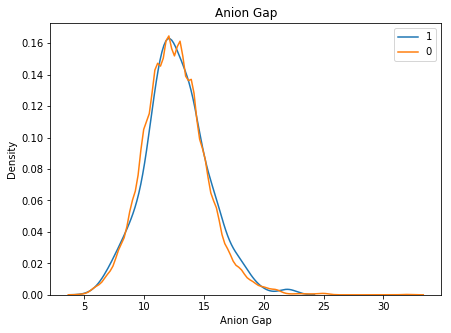

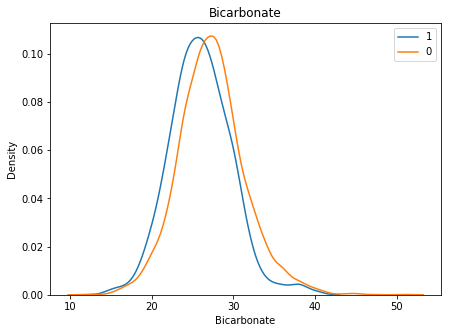

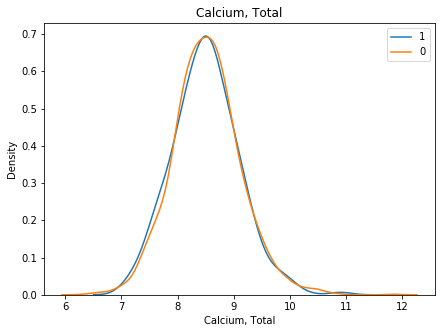

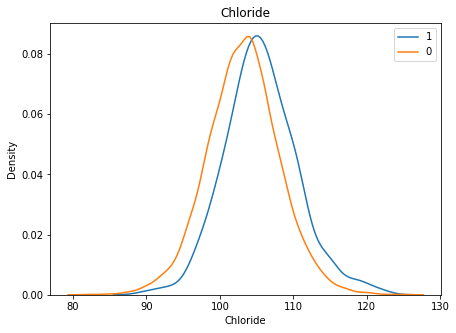

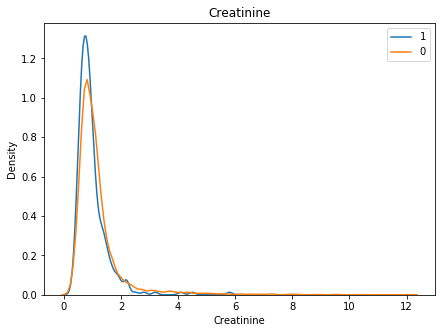

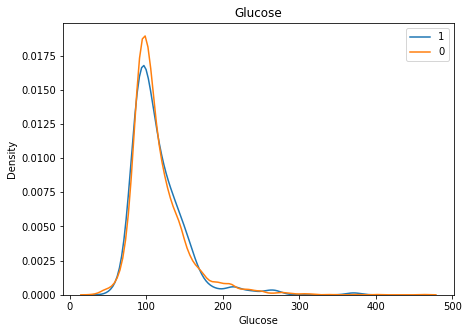

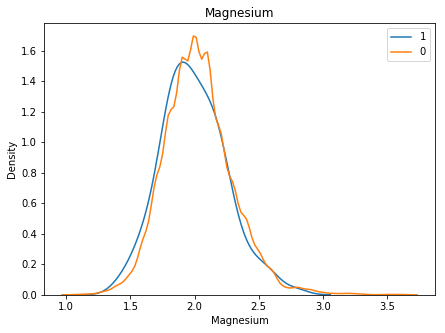

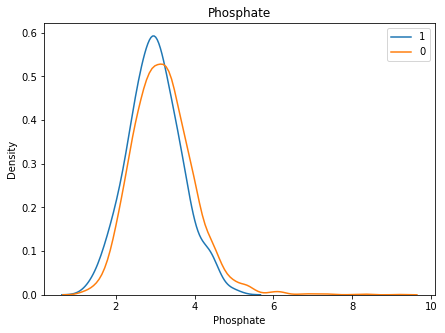

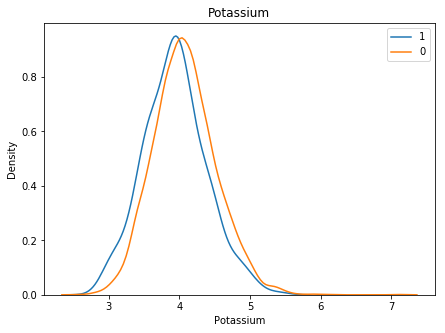

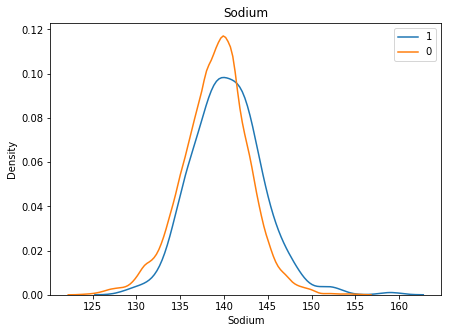

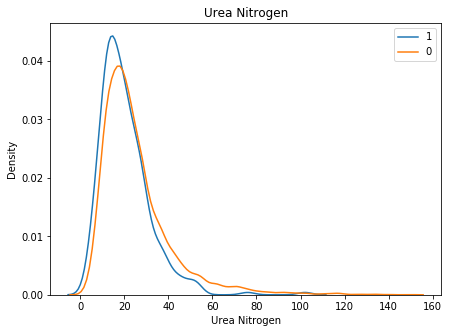

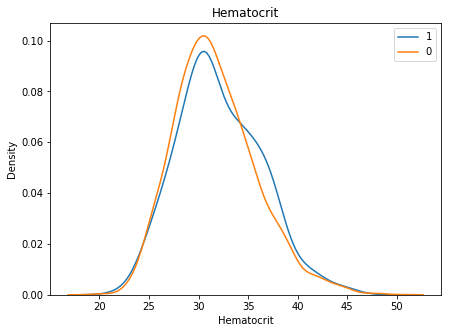

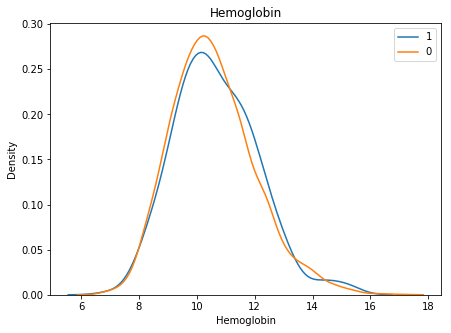

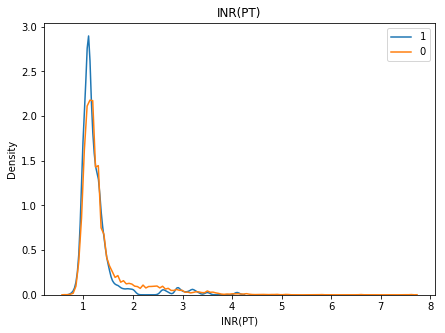

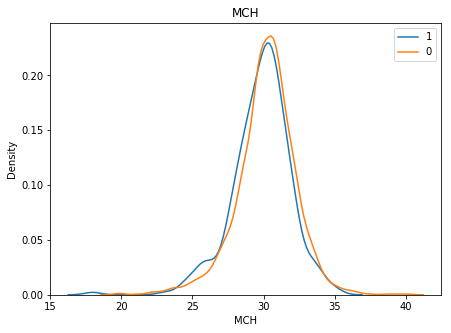

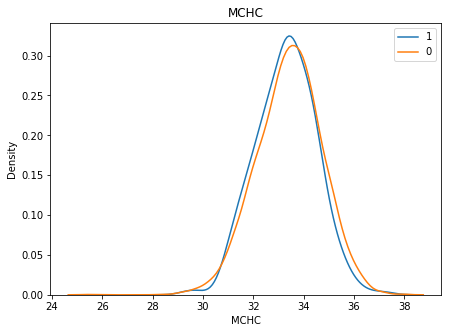

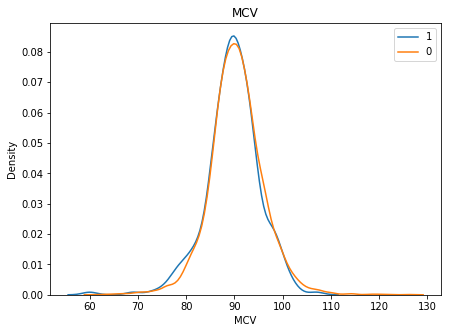

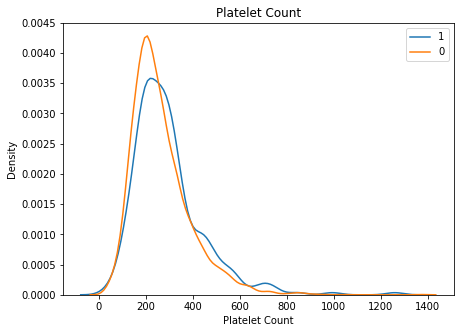

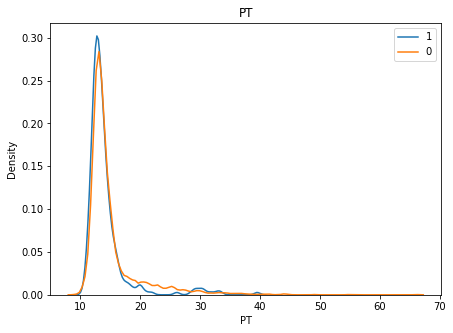

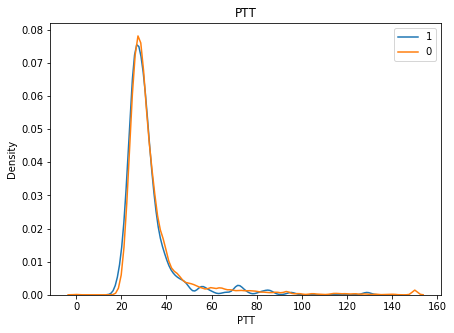

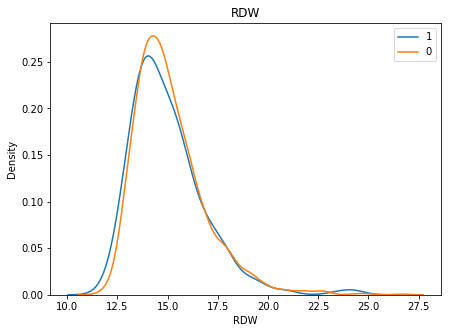

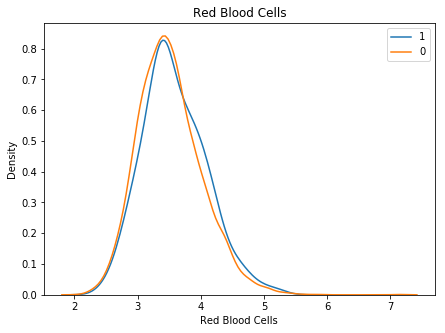

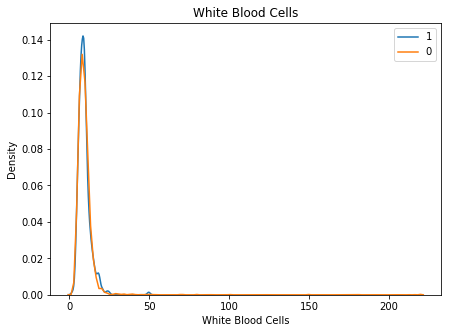

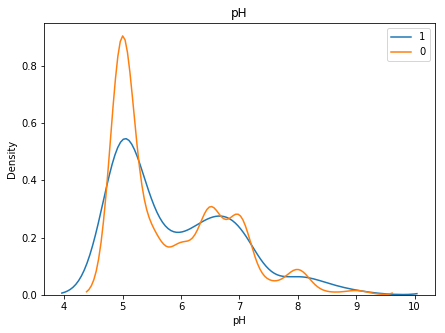

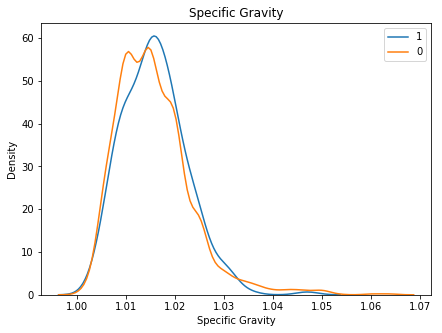

In [8]:
# Plot a KDE for all remaining cols
cols = [c for c in df.columns if c not in ['subject_id', 'hadm_id', 'target']]
for c in cols:
    plot_KDE(df, 'target', 1, 0, c)

In [9]:
# Clean data ready for model

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)

# Split features and labels
features = df.drop(columns=['subject_id', 'hadm_id', 'target'])
labels = np.array(df.target.tolist())

# Impute missing values
imputer = Imputer(strategy = 'median')
imputer.fit(features)
features = imputer.transform(features)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1)) 
scaler.fit(features)
features = scaler.transform(features)

/Users/James/anaconda3/envs/mimic/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(10, 150)),
    'learning_rate': list(np.linspace(0.001, 0.5)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_data_in_leaf': list(range(10, 250, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.001, 1)),
    'subsample': list(np.linspace(0.5, 1)),
    'is_unbalance': [True, False],
    'min_split_gain': list(np.linspace(0.001, 1)),
    'min_data_in_leaf': list(np.arange(1, 200, 3)),
}

In [11]:
# Train a Light GBM

df_cols = list(param_grid.keys())
df_cols = df_cols + ['training_score', 'valid_score']

runs_df = pd.DataFrame(columns=df_cols)
total_runs = 10000
run =0

while run < total_runs:
    
    run += 1
    
    # Select the random parameters
    random_params = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
    
    # Add constant params
    random_params['n_thread'] = 1
    random_params['n_estimators'] = 10000
    random_params['metric'] = 'auc'
    
    print('=========')
    print('RUN IS ' + str(run))
    print('=========')

    metrics, train_score, valid_score = train_lgb(features = features,
                                                 labels = labels,
                                                 n_folds = 5,
                                                 params = random_params,
                                                 eval_metric = 'auc',
                                                 early_stopping_rounds = 500)

    temp_df = pd.DataFrame(columns=df_cols)

    for c in list(param_grid.keys()):
        temp_df.loc[0, c] = random_params[c]
    
    temp_df.loc[0, 'training_score'] = train_score
    temp_df.loc[0, 'valid_score'] = valid_score
    
    runs_df = runs_df.append(temp_df)

    del temp_df, train_score, valid_score

RUN IS 1
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608053	train's auc: 0.998978
Early stopping, best iteration is:
[12]	valid's auc: 0.655952	train's auc: 0.945688
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.648311	train's auc: 0.998892
Early stopping, best iteration is:
[11]	valid's auc: 0.664645	train's auc: 0.939585
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.638127	train's auc: 0.99902
Early stopping, best iteration is:
[13]	valid's auc: 0.653333	train's auc: 0.954625
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.666561	train's auc: 0.99812
Early stopping, best iteration is:
[15]	valid's auc: 0.70002	train's auc: 0.954049
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612548	train's auc: 0.999395
Early stopping, best iteration is:
[14]	valid's auc: 0.652135	train's auc: 0.954

[500]	valid's auc: 0.556899	train's auc: 0.992758
Early stopping, best iteration is:
[75]	valid's auc: 0.625241	train's auc: 0.904382
      fold     train     valid
0        0  0.831179  0.674907
1        1  0.866137  0.656567
2        2  0.872165  0.662571
3        3  0.842716  0.678906
4        4  0.904382  0.625241
5  overall  0.863316  0.654495
RUN IS 8
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593651	train's auc: 0.998488
Early stopping, best iteration is:
[11]	valid's auc: 0.626704	train's auc: 0.875714
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621489	train's auc: 0.999296
Early stopping, best iteration is:
[113]	valid's auc: 0.637428	train's auc: 0.996362
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622571	train's auc: 0.999228
Early stopping, best iteration is:
[9]	valid's auc: 0.649587	train's auc: 0.847493
Training until validation scores don

[500]	valid's auc: 0.651019	train's auc: 0.999871
Early stopping, best iteration is:
[5]	valid's auc: 0.694086	train's auc: 0.901672
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.645803	train's auc: 0.999921
Early stopping, best iteration is:
[33]	valid's auc: 0.647541	train's auc: 0.998294
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.592579	train's auc: 0.999768
Early stopping, best iteration is:
[10]	valid's auc: 0.638051	train's auc: 0.963535
      fold     train     valid
0        0  0.947819  0.666737
1        1  0.944811  0.676338
2        2  0.901672  0.694086
3        3  0.998294  0.647541
4        4  0.963535  0.638051
5  overall  0.951226  0.658224
RUN IS 15
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.517017	train's auc: 0.993025
Early stopping, best iteration is:
[13]	valid's auc: 0.626517	train's auc: 0.805261
Training until validation scores don

[500]	valid's auc: 0.511345	train's auc: 0.612534
Early stopping, best iteration is:
[6]	valid's auc: 0.663329	train's auc: 0.811799
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618487	train's auc: 0.93898
Early stopping, best iteration is:
[6]	valid's auc: 0.658147	train's auc: 0.81134
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626887	train's auc: 0.922191
Early stopping, best iteration is:
[17]	valid's auc: 0.673976	train's auc: 0.895825
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640648	train's auc: 0.946155
Early stopping, best iteration is:
[142]	valid's auc: 0.662572	train's auc: 0.930578
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611291	train's auc: 0.941119
Early stopping, best iteration is:
[4]	valid's auc: 0.625602	train's auc: 0.783591
      fold     train     valid
0        0  0.811799  0.663329
1        1  0.811340

[500]	valid's auc: 0.645026	train's auc: 0.928931
Early stopping, best iteration is:
[242]	valid's auc: 0.660267	train's auc: 0.90273
      fold     train     valid
0        0  0.816683  0.665091
1        1  0.903498  0.684318
2        2  0.891240  0.683306
3        3  0.901168  0.685127
4        4  0.902730  0.660267
5  overall  0.883064  0.649088
RUN IS 28
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58233	train's auc: 0.951141
Early stopping, best iteration is:
[6]	valid's auc: 0.621569	train's auc: 0.864366
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.62619	train's auc: 0.951756
Early stopping, best iteration is:
[68]	valid's auc: 0.601659	train's auc: 0.957127
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618384	train's auc: 0.945363
Early stopping, best iteration is:
[9]	valid's auc: 0.667456	train's auc: 0.877782
Training until validation scores don't 

[500]	valid's auc: 0.647442	train's auc: 0.99999
Early stopping, best iteration is:
[86]	valid's auc: 0.659056	train's auc: 0.999976
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61877	train's auc: 0.999989
Early stopping, best iteration is:
[17]	valid's auc: 0.635996	train's auc: 0.986034
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635552	train's auc: 0.999989
Early stopping, best iteration is:
[149]	valid's auc: 0.66348	train's auc: 0.999982
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626381	train's auc: 1
Early stopping, best iteration is:
[92]	valid's auc: 0.658993	train's auc: 0.999918
      fold     train     valid
0        0  0.998422  0.672479
1        1  0.999976  0.659056
2        2  0.986034  0.635996
3        3  0.999982  0.663480
4        4  0.999918  0.658993
5  overall  0.996866  0.634217
RUN IS 35
LGB starting
Training until validation scores don't impro

[500]	valid's auc: 0.663796	train's auc: 0.948174
Early stopping, best iteration is:
[50]	valid's auc: 0.673296	train's auc: 0.914182
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.676476	train's auc: 0.949799
Early stopping, best iteration is:
[122]	valid's auc: 0.680703	train's auc: 0.91834
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.662994	train's auc: 0.952868
Early stopping, best iteration is:
[8]	valid's auc: 0.683425	train's auc: 0.862816
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.670215	train's auc: 0.955769
Early stopping, best iteration is:
[58]	valid's auc: 0.672171	train's auc: 0.925047
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.643182	train's auc: 0.964772
Early stopping, best iteration is:
[103]	valid's auc: 0.644892	train's auc: 0.940118
      fold     train     valid
0        0  0.914182  0.673296
1        1  0.91

[500]	valid's auc: 0.624419	train's auc: 0.941311
Early stopping, best iteration is:
[14]	valid's auc: 0.652554	train's auc: 0.867905
      fold     train     valid
0        0  0.697330  0.683987
1        1  0.854778  0.686470
2        2  0.799830  0.691524
3        3  0.866328  0.694272
4        4  0.867905  0.652554
5  overall  0.817234  0.666470
RUN IS 48
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622759	train's auc: 0.932527
Early stopping, best iteration is:
[5]	valid's auc: 0.672409	train's auc: 0.800617
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.639957	train's auc: 0.925701
Early stopping, best iteration is:
[12]	valid's auc: 0.679281	train's auc: 0.873164
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59449	train's auc: 0.929587
Early stopping, best iteration is:
[6]	valid's auc: 0.671745	train's auc: 0.810523
Training until validation scores don't

[500]	valid's auc: 0.6564	train's auc: 0.77746
Early stopping, best iteration is:
[4]	valid's auc: 0.6736	train's auc: 0.82273
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.679242	train's auc: 0.780342
Early stopping, best iteration is:
[24]	valid's auc: 0.700474	train's auc: 0.833104
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644657	train's auc: 0.798344
Early stopping, best iteration is:
[44]	valid's auc: 0.640801	train's auc: 0.851884
      fold     train     valid
0        0  0.827978  0.666106
1        1  0.841821  0.679735
2        2  0.822730  0.673600
3        3  0.833104  0.700474
4        4  0.851884  0.640801
5  overall  0.835503  0.545798
RUN IS 55
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60712	train's auc: 0.967576
Early stopping, best iteration is:
[3]	valid's auc: 0.629995	train's auc: 0.826084
Training until validation scores don't impro

[500]	valid's auc: 0.619141	train's auc: 0.960226
Early stopping, best iteration is:
[24]	valid's auc: 0.664262	train's auc: 0.857865
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.648193	train's auc: 0.963519
Early stopping, best iteration is:
[84]	valid's auc: 0.660577	train's auc: 0.884497
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.660514	train's auc: 0.97164
Early stopping, best iteration is:
[86]	valid's auc: 0.682902	train's auc: 0.913558
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.663006	train's auc: 0.970172
Early stopping, best iteration is:
[33]	valid's auc: 0.693581	train's auc: 0.876374
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.642176	train's auc: 0.967648
Early stopping, best iteration is:
[23]	valid's auc: 0.661407	train's auc: 0.867531
      fold     train     valid
0        0  0.857865  0.664262
1        1  0.884

[500]	valid's auc: 0.549219	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.63344	train's auc: 0.863532
      fold     train     valid
0        0  0.941158  0.638445
1        1  0.872354  0.682975
2        2  0.866513  0.682057
3        3  0.849849  0.700168
4        4  0.863532  0.633440
5  overall  0.878681  0.663025
RUN IS 68
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632283	train's auc: 0.931247
Early stopping, best iteration is:
[10]	valid's auc: 0.689729	train's auc: 0.846815
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.64284	train's auc: 0.935552
Early stopping, best iteration is:
[7]	valid's auc: 0.669978	train's auc: 0.826979
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631827	train's auc: 0.935082
Early stopping, best iteration is:
[10]	valid's auc: 0.684132	train's auc: 0.850983
Training until validation scores don't improve

[500]	valid's auc: 0.632342	train's auc: 0.996262
Early stopping, best iteration is:
[36]	valid's auc: 0.639027	train's auc: 0.998795
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.658167	train's auc: 0.993181
Early stopping, best iteration is:
[45]	valid's auc: 0.671973	train's auc: 0.998045
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.649637	train's auc: 0.99551
Early stopping, best iteration is:
[18]	valid's auc: 0.626566	train's auc: 0.997186
      fold     train     valid
0        0  0.998670  0.604038
1        1  0.999095  0.632372
2        2  0.998795  0.639027
3        3  0.998045  0.671973
4        4  0.997186  0.626566
5  overall  0.998359  0.580189
RUN IS 75
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.55049	train's auc: 0.999314
Early stopping, best iteration is:
[36]	valid's auc: 0.637488	train's auc: 0.957915
Training until validation scores don'

[500]	valid's auc: 0.612278	train's auc: 0.954073
Early stopping, best iteration is:
[36]	valid's auc: 0.624603	train's auc: 0.927055
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.599723	train's auc: 0.968427
Early stopping, best iteration is:
[23]	valid's auc: 0.619119	train's auc: 0.892685
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629091	train's auc: 0.966451
Early stopping, best iteration is:
[35]	valid's auc: 0.674399	train's auc: 0.915646
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586865	train's auc: 0.960776
Early stopping, best iteration is:
[121]	valid's auc: 0.58256	train's auc: 0.96098
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605422	train's auc: 0.966442
Early stopping, best iteration is:
[6]	valid's auc: 0.626079	train's auc: 0.761448
      fold     train     valid
0        0  0.927055  0.624603
1        1  0.8926

[500]	valid's auc: 0.625627	train's auc: 0.940271
Early stopping, best iteration is:
[49]	valid's auc: 0.655371	train's auc: 0.828189
      fold     train     valid
0        0  0.826096  0.592414
1        1  0.811962  0.651215
2        2  0.860249  0.660533
3        3  0.887462  0.583231
4        4  0.828189  0.655371
5  overall  0.842792  0.628203
RUN IS 88
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583497	train's auc: 0.97689
Early stopping, best iteration is:
[12]	valid's auc: 0.59232	train's auc: 0.966875
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594154	train's auc: 0.983083
Early stopping, best iteration is:
[2]	valid's auc: 0.612868	train's auc: 0.799661
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.588944	train's auc: 0.972727
Early stopping, best iteration is:
[4]	valid's auc: 0.640129	train's auc: 0.883197
Training until validation scores don't 

[500]	valid's auc: 0.62022	train's auc: 0.999989
Early stopping, best iteration is:
[5]	valid's auc: 0.655629	train's auc: 0.886165
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627059	train's auc: 0.999989
Early stopping, best iteration is:
[50]	valid's auc: 0.614774	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.550443	train's auc: 1
Early stopping, best iteration is:
[38]	valid's auc: 0.567646	train's auc: 1
      fold     train     valid
0        0  0.857224  0.606933
1        1  0.999990  0.601106
2        2  0.886165  0.655629
3        3  0.999989  0.614774
4        4  1.000000  0.567646
5  overall  0.948674  0.575885
RUN IS 95
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610668	train's auc: 0.999986
Early stopping, best iteration is:
[38]	valid's auc: 0.655626	train's auc: 0.991006
Training until validation scores don't improve for 

[500]	valid's auc: 0.546942	train's auc: 0.998213
Early stopping, best iteration is:
[23]	valid's auc: 0.598483	train's auc: 0.854133
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594331	train's auc: 0.998066
Early stopping, best iteration is:
[160]	valid's auc: 0.651787	train's auc: 0.960481
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.579265	train's auc: 0.999463
Early stopping, best iteration is:
[22]	valid's auc: 0.655886	train's auc: 0.829069
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59763	train's auc: 0.998434
Early stopping, best iteration is:
[283]	valid's auc: 0.618724	train's auc: 0.990065
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.550578	train's auc: 0.999429
Early stopping, best iteration is:
[12]	valid's auc: 0.649159	train's auc: 0.79575
      fold     train     valid
0        0  0.854133  0.598483
1        1  0.96

[500]	valid's auc: 0.640499	train's auc: 0.833317
Early stopping, best iteration is:
[56]	valid's auc: 0.668215	train's auc: 0.822165
      fold     train     valid
0        0  0.842860  0.627264
1        1  0.848857  0.622457
2        2  0.844900  0.666667
3        3  0.845644  0.642722
4        4  0.822165  0.668215
5  overall  0.840885  0.582201
RUN IS 108
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.6345	train's auc: 0.959191
Early stopping, best iteration is:
[59]	valid's auc: 0.639683	train's auc: 0.963343
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.659392	train's auc: 0.967563
Early stopping, best iteration is:
[5]	valid's auc: 0.679676	train's auc: 0.832225
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.658402	train's auc: 0.964883
Early stopping, best iteration is:
[19]	valid's auc: 0.67562	train's auc: 0.905397
Training until validation scores don't

[500]	valid's auc: 0.667885	train's auc: 0.816294
Early stopping, best iteration is:
[37]	valid's auc: 0.619771	train's auc: 0.85283
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653811	train's auc: 0.826756
Early stopping, best iteration is:
[30]	valid's auc: 0.657539	train's auc: 0.842251
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606143	train's auc: 0.824536
Early stopping, best iteration is:
[30]	valid's auc: 0.562019	train's auc: 0.850766
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634882	train's auc: 0.827966
Early stopping, best iteration is:
[32]	valid's auc: 0.604936	train's auc: 0.855079
      fold     train     valid
0        0  0.844360  0.595892
1        1  0.852830  0.619771
2        2  0.842251  0.657539
3        3  0.850766  0.562019
4        4  0.855079  0.604936
5  overall  0.849057  0.502553
RUN IS 115
LGB starting
Training until validation scores do

[500]	valid's auc: 0.562512	train's auc: 0.946625
Early stopping, best iteration is:
[16]	valid's auc: 0.583754	train's auc: 0.919994
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594568	train's auc: 0.949135
Early stopping, best iteration is:
[8]	valid's auc: 0.626012	train's auc: 0.874459
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635133	train's auc: 0.953031
Early stopping, best iteration is:
[5]	valid's auc: 0.659881	train's auc: 0.842672
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640371	train's auc: 0.953448
Early stopping, best iteration is:
[5]	valid's auc: 0.656241	train's auc: 0.844337
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625258	train's auc: 0.956638
Early stopping, best iteration is:
[9]	valid's auc: 0.635955	train's auc: 0.897462
      fold     train     valid
0        0  0.919994  0.583754
1        1  0.874459

[500]	valid's auc: 0.578864	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.603092	train's auc: 0.720741
      fold     train     valid
0        0  0.956672  0.600980
1        1  0.771006  0.643008
2        2  0.774651  0.645657
3        3  0.999912  0.631266
4        4  0.720741  0.603092
5  overall  0.844596  0.615370
RUN IS 128
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603361	train's auc: 0.988322
Early stopping, best iteration is:
[50]	valid's auc: 0.629062	train's auc: 0.94833
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619277	train's auc: 0.991213
Early stopping, best iteration is:
[33]	valid's auc: 0.675509	train's auc: 0.921439
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.633517	train's auc: 0.98704
Early stopping, best iteration is:
[33]	valid's auc: 0.661433	train's auc: 0.919596
Training until validation scores don't impro

[500]	valid's auc: 0.617484	train's auc: 0.999989
Early stopping, best iteration is:
[9]	valid's auc: 0.709146	train's auc: 0.9007
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586806	train's auc: 0.999989
Early stopping, best iteration is:
[36]	valid's auc: 0.621786	train's auc: 0.972032
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.546168	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.614393	train's auc: 0.889715
      fold     train     valid
0        0  0.927702  0.595612
1        1  0.989413  0.638515
2        2  0.900700  0.709146
3        3  0.972032  0.621786
4        4  0.889715  0.614393
5  overall  0.935912  0.634353
RUN IS 135
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61599	train's auc: 0.999988
Early stopping, best iteration is:
[46]	valid's auc: 0.631092	train's auc: 0.999224
Training until validation scores don't improve

[500]	valid's auc: 0.631723	train's auc: 0.999988
Early stopping, best iteration is:
[43]	valid's auc: 0.673296	train's auc: 0.99738
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.646889	train's auc: 0.99999
Early stopping, best iteration is:
[32]	valid's auc: 0.684436	train's auc: 0.997216
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622645	train's auc: 0.999989
Early stopping, best iteration is:
[126]	valid's auc: 0.662443	train's auc: 0.999692
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640154	train's auc: 0.999989
Early stopping, best iteration is:
[247]	valid's auc: 0.651234	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610888	train's auc: 1
Early stopping, best iteration is:
[134]	valid's auc: 0.637179	train's auc: 0.999935
      fold     train     valid
0        0  0.997380  0.673296
1        1  0.997216  

[500]	valid's auc: 0.625442	train's auc: 0.98267
Early stopping, best iteration is:
[35]	valid's auc: 0.651347	train's auc: 0.906998
      fold     train     valid
0        0  0.907900  0.649416
1        1  0.915305  0.683212
2        2  0.896220  0.683196
3        3  0.875283  0.696445
4        4  0.906998  0.651347
5  overall  0.900341  0.669852
RUN IS 148
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.582423	train's auc: 0.999552
Early stopping, best iteration is:
[18]	valid's auc: 0.628852	train's auc: 0.956493
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58813	train's auc: 0.999775
Early stopping, best iteration is:
[6]	valid's auc: 0.629676	train's auc: 0.842437
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610119	train's auc: 0.999572
Early stopping, best iteration is:
[26]	valid's auc: 0.635096	train's auc: 0.976476
Training until validation scores don'

[500]	valid's auc: 0.608944	train's auc: 0.999653
Early stopping, best iteration is:
[7]	valid's auc: 0.666612	train's auc: 0.85242
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.647462	train's auc: 0.999746
Early stopping, best iteration is:
[7]	valid's auc: 0.709382	train's auc: 0.863027
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.558928	train's auc: 0.999857
Early stopping, best iteration is:
[5]	valid's auc: 0.655858	train's auc: 0.850858
      fold     train     valid
0        0  0.743920  0.658462
1        1  0.846976  0.679538
2        2  0.852420  0.666612
3        3  0.863027  0.709382
4        4  0.850858  0.655858
5  overall  0.831440  0.670189
RUN IS 155
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.571592	train's auc: 0.995722
Early stopping, best iteration is:
[24]	valid's auc: 0.673623	train's auc: 0.899111
Training until validation scores don't

[500]	valid's auc: 0.555952	train's auc: 0.999988
Early stopping, best iteration is:
[7]	valid's auc: 0.651611	train's auc: 0.850273
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614162	train's auc: 0.99999
Early stopping, best iteration is:
[31]	valid's auc: 0.637922	train's auc: 0.962615
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60123	train's auc: 0.999989
Early stopping, best iteration is:
[7]	valid's auc: 0.657365	train's auc: 0.865427
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605945	train's auc: 0.999989
Early stopping, best iteration is:
[27]	valid's auc: 0.648943	train's auc: 0.950893
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.556262	train's auc: 1
Early stopping, best iteration is:
[8]	valid's auc: 0.63515	train's auc: 0.856684
      fold     train     valid
0        0  0.850273  0.651611
1        1  0.962615  0.63792

[500]	valid's auc: 0.625325	train's auc: 0.999728
Early stopping, best iteration is:
[12]	valid's auc: 0.62556	train's auc: 0.969734
      fold     train     valid
0        0  0.996706  0.621545
1        1  0.998789  0.640766
2        2  0.933337  0.659853
3        3  0.883301  0.633992
4        4  0.969734  0.625560
5  overall  0.956373  0.628907
RUN IS 168
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595985	train's auc: 0.998638
Early stopping, best iteration is:
[32]	valid's auc: 0.615406	train's auc: 0.988536
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640964	train's auc: 0.999788
Early stopping, best iteration is:
[20]	valid's auc: 0.678708	train's auc: 0.966635
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625767	train's auc: 0.999449
Early stopping, best iteration is:
[13]	valid's auc: 0.65877	train's auc: 0.952173
Training until validation scores don

[500]	valid's auc: 0.643728	train's auc: 0.895798
Early stopping, best iteration is:
[14]	valid's auc: 0.651864	train's auc: 0.891499
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.624215	train's auc: 0.891411
Early stopping, best iteration is:
[4]	valid's auc: 0.682293	train's auc: 0.806448
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623279	train's auc: 0.904272
Early stopping, best iteration is:
[8]	valid's auc: 0.639912	train's auc: 0.861131
      fold     train     valid
0        0  0.773800  0.676692
1        1  0.861960  0.637883
2        2  0.891499  0.651864
3        3  0.806448  0.682293
4        4  0.861131  0.639912
5  overall  0.838968  0.646862
RUN IS 175
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593277	train's auc: 0.999986
Early stopping, best iteration is:
[10]	valid's auc: 0.630345	train's auc: 0.906524
Training until validation scores don

[500]	valid's auc: 0.578852	train's auc: 0.999988
Early stopping, best iteration is:
[1]	valid's auc: 0.59525	train's auc: 0.85353
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.511535	train's auc: 0.99999
Early stopping, best iteration is:
[1]	valid's auc: 0.535572	train's auc: 0.855379
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609054	train's auc: 0.999989
Early stopping, best iteration is:
[11]	valid's auc: 0.600533	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619791	train's auc: 0.999989
Early stopping, best iteration is:
[11]	valid's auc: 0.615998	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.592361	train's auc: 1
Early stopping, best iteration is:
[11]	valid's auc: 0.559414	train's auc: 1
      fold     train     valid
0        0  0.853530  0.595250
1        1  0.855379  0.535572
2   

[318]	valid's auc: 0.676318	train's auc: 0.929569
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.638604	train's auc: 0.941584
Early stopping, best iteration is:
[19]	valid's auc: 0.673413	train's auc: 0.883567
      fold     train     valid
0        0  0.925588  0.646008
1        1  0.927746  0.676536
2        2  0.899357  0.698017
3        3  0.929569  0.676318
4        4  0.883567  0.673413
5  overall  0.913165  0.562532
RUN IS 188
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.568721	train's auc: 0.997721
Early stopping, best iteration is:
[49]	valid's auc: 0.618371	train's auc: 0.948198
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.559214	train's auc: 0.997852
Early stopping, best iteration is:
[52]	valid's auc: 0.612167	train's auc: 0.959112
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.572378	train's auc: 0.997732
Early

[500]	valid's auc: 0.584515	train's auc: 0.99999
Early stopping, best iteration is:
[37]	valid's auc: 0.6413	train's auc: 0.989583
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.5991	train's auc: 0.999989
Early stopping, best iteration is:
[4]	valid's auc: 0.675877	train's auc: 0.800945
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629212	train's auc: 0.999989
Early stopping, best iteration is:
[6]	valid's auc: 0.66669	train's auc: 0.837426
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.563505	train's auc: 1
Early stopping, best iteration is:
[12]	valid's auc: 0.624939	train's auc: 0.908813
      fold     train     valid
0        0  0.921466  0.657680
1        1  0.989583  0.641300
2        2  0.800945  0.675877
3        3  0.837426  0.666690
4        4  0.908813  0.624939
5  overall  0.891647  0.644848
RUN IS 195
LGB starting
Training until validation scores don't improve fo

[500]	valid's auc: 0.628525	train's auc: 0.951263
Early stopping, best iteration is:
[196]	valid's auc: 0.642484	train's auc: 0.89812
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.659668	train's auc: 0.944461
Early stopping, best iteration is:
[6]	valid's auc: 0.683853	train's auc: 0.790868
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.657649	train's auc: 0.951231
Early stopping, best iteration is:
[227]	valid's auc: 0.680624	train's auc: 0.905894
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.671578	train's auc: 0.943444
Early stopping, best iteration is:
[115]	valid's auc: 0.690144	train's auc: 0.86542
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.648078	train's auc: 0.959288
Early stopping, best iteration is:
[9]	valid's auc: 0.66238	train's auc: 0.810694
      fold     train     valid
0        0  0.898120  0.642484
1        1  0.7908

[500]	valid's auc: 0.616707	train's auc: 0.992139
Early stopping, best iteration is:
[8]	valid's auc: 0.626281	train's auc: 0.985539
      fold     train     valid
0        0  0.987185  0.627404
1        1  0.880422  0.668280
2        2  0.833113  0.551625
3        3  0.990136  0.619593
4        4  0.985539  0.626281
5  overall  0.935279  0.611334
RUN IS 208
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594865	train's auc: 0.999988
Early stopping, best iteration is:
[15]	valid's auc: 0.631232	train's auc: 0.990457
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615742	train's auc: 0.999986
Early stopping, best iteration is:
[4]	valid's auc: 0.663717	train's auc: 0.884788
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.576878	train's auc: 0.999989
Early stopping, best iteration is:
[4]	valid's auc: 0.631543	train's auc: 0.894534
Training until validation scores don'

[500]	valid's auc: 0.630817	train's auc: 0.999989
Early stopping, best iteration is:
[6]	valid's auc: 0.654013	train's auc: 0.857088
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622694	train's auc: 0.999989
Early stopping, best iteration is:
[207]	valid's auc: 0.610172	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601298	train's auc: 1
Early stopping, best iteration is:
[13]	valid's auc: 0.616908	train's auc: 0.93488
      fold     train     valid
0        0  0.999988  0.541293
1        1  0.709248  0.641655
2        2  0.857088  0.654013
3        3  0.999989  0.610172
4        4  0.934880  0.616908
5  overall  0.900239  0.599853
RUN IS 215
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63226	train's auc: 0.989837
Early stopping, best iteration is:
[9]	valid's auc: 0.643301	train's auc: 0.924475
Training until validation scores don't impro

[500]	valid's auc: 0.502731	train's auc: 0.996654
Early stopping, best iteration is:
[8]	valid's auc: 0.625934	train's auc: 0.776674
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.573296	train's auc: 0.996121
Early stopping, best iteration is:
[28]	valid's auc: 0.690361	train's auc: 0.816728
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.580367	train's auc: 0.994163
Early stopping, best iteration is:
[17]	valid's auc: 0.664334	train's auc: 0.810669
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621786	train's auc: 0.996658
Early stopping, best iteration is:
[25]	valid's auc: 0.680111	train's auc: 0.811603
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.543334	train's auc: 0.994761
Early stopping, best iteration is:
[10]	valid's auc: 0.631562	train's auc: 0.782281
      fold     train     valid
0        0  0.776674  0.625934
1        1  0.816

[500]	valid's auc: 0.591757	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.64449	train's auc: 0.776746
      fold     train     valid
0        0  0.987685  0.633100
1        1  0.999959  0.611811
2        2  0.999896  0.609238
3        3  0.999923  0.607387
4        4  0.776746  0.644490
5  overall  0.952842  0.596866
RUN IS 228
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603151	train's auc: 0.99993
Early stopping, best iteration is:
[32]	valid's auc: 0.632049	train's auc: 0.94504
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.65718	train's auc: 0.999976
Early stopping, best iteration is:
[34]	valid's auc: 0.683251	train's auc: 0.957923
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608577	train's auc: 0.999964
Early stopping, best iteration is:
[5]	valid's auc: 0.692929	train's auc: 0.866531
Training until validation scores don't improve 

[500]	valid's auc: 0.623958	train's auc: 0.947513
Early stopping, best iteration is:
[26]	valid's auc: 0.690658	train's auc: 0.817405
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.589513	train's auc: 0.943728
Early stopping, best iteration is:
[19]	valid's auc: 0.68292	train's auc: 0.809378
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611159	train's auc: 0.938708
Early stopping, best iteration is:
[9]	valid's auc: 0.707821	train's auc: 0.786392
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.572425	train's auc: 0.931919
Early stopping, best iteration is:
[8]	valid's auc: 0.625996	train's auc: 0.806645
      fold     train     valid
0        0  0.810004  0.655766
1        1  0.817405  0.690658
2        2  0.809378  0.682920
3        3  0.786392  0.707821
4        4  0.806645  0.625996
5  overall  0.805965  0.672313
RUN IS 235
LGB starting
Training until validation scores don'

[500]	valid's auc: 0.596172	train's auc: 0.998865
Early stopping, best iteration is:
[15]	valid's auc: 0.677638	train's auc: 0.861686
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615169	train's auc: 0.999347
Early stopping, best iteration is:
[38]	valid's auc: 0.68649	train's auc: 0.893411
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60011	train's auc: 0.999749
Early stopping, best iteration is:
[7]	valid's auc: 0.658972	train's auc: 0.855896
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623306	train's auc: 0.999863
Early stopping, best iteration is:
[26]	valid's auc: 0.704661	train's auc: 0.882778
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.561845	train's auc: 0.999781
Early stopping, best iteration is:
[18]	valid's auc: 0.625157	train's auc: 0.875032
      fold     train     valid
0        0  0.861686  0.677638
1        1  0.89341

[500]	valid's auc: 0.610436	train's auc: 0.999946
Early stopping, best iteration is:
[4]	valid's auc: 0.64039	train's auc: 0.84465
      fold     train     valid
0        0  0.981706  0.574090
1        1  0.998599  0.650444
2        2  0.949835  0.636676
3        3  0.999886  0.617085
4        4  0.844650  0.640390
5  overall  0.954935  0.622515
RUN IS 248
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622689	train's auc: 0.954785
Early stopping, best iteration is:
[1]	valid's auc: 0.625607	train's auc: 0.731033
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.613944	train's auc: 0.966387
Early stopping, best iteration is:
[14]	valid's auc: 0.619771	train's auc: 0.930663
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611534	train's auc: 0.954505
Early stopping, best iteration is:
[3]	valid's auc: 0.665133	train's auc: 0.810148
Training until validation scores don't 

[500]	valid's auc: 0.618641	train's auc: 0.999953
Early stopping, best iteration is:
[188]	valid's auc: 0.635629	train's auc: 0.999175
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631622	train's auc: 0.999943
Early stopping, best iteration is:
[54]	valid's auc: 0.635019	train's auc: 0.985144
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605456	train's auc: 0.999997
Early stopping, best iteration is:
[62]	valid's auc: 0.61555	train's auc: 0.994515
      fold     train     valid
0        0  0.834358  0.660668
1        1  0.975559  0.641082
2        2  0.999175  0.635629
3        3  0.985144  0.635019
4        4  0.994515  0.615550
5  overall  0.957750  0.613449
RUN IS 255
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574883	train's auc: 0.98557
Early stopping, best iteration is:
[11]	valid's auc: 0.633217	train's auc: 0.877373
Training until validation scores do

[500]	valid's auc: 0.619701	train's auc: 0.999984
Early stopping, best iteration is:
[48]	valid's auc: 0.638585	train's auc: 0.998439
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586589	train's auc: 0.999988
Early stopping, best iteration is:
[53]	valid's auc: 0.613549	train's auc: 0.998908
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.630854	train's auc: 0.999979
Early stopping, best iteration is:
[1]	valid's auc: 0.660661	train's auc: 0.730336
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61665	train's auc: 0.999987
Early stopping, best iteration is:
[66]	valid's auc: 0.630851	train's auc: 0.999451
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.558877	train's auc: 1
Early stopping, best iteration is:
[7]	valid's auc: 0.58002	train's auc: 0.931212
      fold     train     valid
0        0  0.998439  0.638585
1        1  0.998908  0.613

[500]	valid's auc: 0.639057	train's auc: 0.986792
Early stopping, best iteration is:
[313]	valid's auc: 0.649436	train's auc: 0.966788
      fold     train     valid
0        0  0.865812  0.663539
1        1  0.911884  0.704385
2        2  0.922452  0.672470
3        3  0.880277  0.701481
4        4  0.966788  0.649436
5  overall  0.909443  0.541091
RUN IS 268
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60782	train's auc: 0.972179
Early stopping, best iteration is:
[4]	valid's auc: 0.652894	train's auc: 0.851482
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.654355	train's auc: 0.96656
Early stopping, best iteration is:
[13]	valid's auc: 0.667885	train's auc: 0.945336
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.637998	train's auc: 0.955457
Early stopping, best iteration is:
[4]	valid's auc: 0.668053	train's auc: 0.845194
Training until validation scores don'

[500]	valid's auc: 0.6409	train's auc: 0.928645
Early stopping, best iteration is:
[35]	valid's auc: 0.6636	train's auc: 0.825216
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611811	train's auc: 0.934109
Early stopping, best iteration is:
[246]	valid's auc: 0.619652	train's auc: 0.914865
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615952	train's auc: 0.932488
Early stopping, best iteration is:
[56]	valid's auc: 0.679633	train's auc: 0.859827
      fold     train     valid
0        0  0.891386  0.642017
1        1  0.737656  0.646711
2        2  0.825216  0.663600
3        3  0.914865  0.619652
4        4  0.859827  0.679633
5  overall  0.845790  0.643620
RUN IS 275
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640896	train's auc: 0.999704
Early stopping, best iteration is:
[8]	valid's auc: 0.656139	train's auc: 0.980079
Training until validation scores don't

[500]	valid's auc: 0.639076	train's auc: 0.928713
Early stopping, best iteration is:
[3]	valid's auc: 0.642822	train's auc: 0.78561
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595536	train's auc: 0.925366
Early stopping, best iteration is:
[2]	valid's auc: 0.618033	train's auc: 0.762599
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.668301	train's auc: 0.930119
Early stopping, best iteration is:
[5]	valid's auc: 0.691515	train's auc: 0.828183
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653427	train's auc: 0.919143
Early stopping, best iteration is:
[4]	valid's auc: 0.691892	train's auc: 0.804894
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.6017	train's auc: 0.933674
Early stopping, best iteration is:
[5]	valid's auc: 0.619959	train's auc: 0.828863
      fold     train     valid
0        0  0.785610  0.642822
1        1  0.762599  0.

[500]	valid's auc: 0.614024	train's auc: 0.890071
Early stopping, best iteration is:
[22]	valid's auc: 0.643668	train's auc: 0.825459
      fold     train     valid
0        0  0.857145  0.618838
1        1  0.869564  0.655343
2        2  0.841606  0.668026
3        3  0.879007  0.645171
4        4  0.825459  0.643668
5  overall  0.854556  0.484451
RUN IS 288
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.647316	train's auc: 0.998967
Early stopping, best iteration is:
[10]	valid's auc: 0.659314	train's auc: 0.964386
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.660438	train's auc: 0.999307
Early stopping, best iteration is:
[182]	valid's auc: 0.67778	train's auc: 0.996687
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.651974	train's auc: 0.999362
Early stopping, best iteration is:
[131]	valid's auc: 0.664059	train's auc: 0.995387
Training until validation scores 

[500]	valid's auc: 0.653848	train's auc: 0.990337
Early stopping, best iteration is:
[205]	valid's auc: 0.676786	train's auc: 0.936423
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.661545	train's auc: 0.984475
Early stopping, best iteration is:
[221]	valid's auc: 0.682007	train's auc: 0.940042
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632619	train's auc: 0.992952
Early stopping, best iteration is:
[274]	valid's auc: 0.654667	train's auc: 0.959859
      fold     train     valid
0        0  0.861575  0.657796
1        1  0.849316  0.686391
2        2  0.936423  0.676786
3        3  0.940042  0.682007
4        4  0.959859  0.654667
5  overall  0.909443  0.523703
RUN IS 295
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586228	train's auc: 0.998168
Early stopping, best iteration is:
[12]	valid's auc: 0.647596	train's auc: 0.880122
Training until validation score

[500]	valid's auc: 0.552918	train's auc: 0.999984
Early stopping, best iteration is:
[33]	valid's auc: 0.668954	train's auc: 0.911631
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574442	train's auc: 0.99999
Early stopping, best iteration is:
[11]	valid's auc: 0.657703	train's auc: 0.869029
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.578421	train's auc: 0.999982
Early stopping, best iteration is:
[44]	valid's auc: 0.657668	train's auc: 0.9264
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609323	train's auc: 0.999989
Early stopping, best iteration is:
[15]	valid's auc: 0.693127	train's auc: 0.869184
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.544391	train's auc: 1
Early stopping, best iteration is:
[19]	valid's auc: 0.641186	train's auc: 0.886862
      fold     train     valid
0        0  0.911631  0.668954
1        1  0.869029  0.65

[500]	valid's auc: 0.567278	train's auc: 1
Early stopping, best iteration is:
[6]	valid's auc: 0.66051	train's auc: 0.844981
      fold     train     valid
0        0  0.904744  0.614262
1        1  0.915217  0.657101
2        2  0.900079  0.665877
3        3  0.883240  0.683863
4        4  0.844981  0.660510
5  overall  0.889652  0.656958
RUN IS 308
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.496592	train's auc: 0.999491
Early stopping, best iteration is:
[6]	valid's auc: 0.580299	train's auc: 0.889661
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.577938	train's auc: 0.999936
Early stopping, best iteration is:
[2]	valid's auc: 0.635295	train's auc: 0.789086
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.573095	train's auc: 0.994733
Early stopping, best iteration is:
[3]	valid's auc: 0.631901	train's auc: 0.824755
Training until validation scores don't improve

[500]	valid's auc: 0.610266	train's auc: 0.954076
Early stopping, best iteration is:
[150]	valid's auc: 0.642296	train's auc: 0.884952
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632254	train's auc: 0.953736
Early stopping, best iteration is:
[54]	valid's auc: 0.696366	train's auc: 0.814131
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.589091	train's auc: 0.957479
Early stopping, best iteration is:
[228]	valid's auc: 0.616673	train's auc: 0.915589
      fold     train     valid
0        0  0.775041  0.618557
1        1  0.848742  0.626388
2        2  0.884952  0.642296
3        3  0.814131  0.696366
4        4  0.915589  0.616673
5  overall  0.847691  0.633139
RUN IS 315
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.532026	train's auc: 0.999988
Early stopping, best iteration is:
[1]	valid's auc: 0.559629	train's auc: 0.923382
Training until validation scores 

[500]	valid's auc: 0.550117	train's auc: 0.999972
Early stopping, best iteration is:
[11]	valid's auc: 0.602101	train's auc: 0.922194
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618744	train's auc: 0.999988
Early stopping, best iteration is:
[35]	valid's auc: 0.627573	train's auc: 0.985596
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.571019	train's auc: 0.999593
Early stopping, best iteration is:
[17]	valid's auc: 0.612287	train's auc: 0.94667
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593206	train's auc: 0.99997
Early stopping, best iteration is:
[38]	valid's auc: 0.603713	train's auc: 0.989939
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602505	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.651917	train's auc: 0.794099
      fold     train     valid
0        0  0.922194  0.602101
1        1  0.985596  0.62

[500]	valid's auc: 0.605573	train's auc: 0.998984
Early stopping, best iteration is:
[42]	valid's auc: 0.610905	train's auc: 0.997817
      fold     train     valid
0        0  0.890582  0.587885
1        1  0.975207  0.594904
2        2  0.995778  0.580771
3        3  0.999655  0.580980
4        4  0.997817  0.610905
5  overall  0.971808  0.572505
RUN IS 328
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606092	train's auc: 0.99147
Early stopping, best iteration is:
[13]	valid's auc: 0.669514	train's auc: 0.84741
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635019	train's auc: 0.99435
Early stopping, best iteration is:
[9]	valid's auc: 0.685009	train's auc: 0.844066
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636382	train's auc: 0.993744
Early stopping, best iteration is:
[149]	valid's auc: 0.65168	train's auc: 0.990557
Training until validation scores don't

[500]	valid's auc: 0.648926	train's auc: 0.999407
Early stopping, best iteration is:
[139]	valid's auc: 0.663471	train's auc: 0.999142
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.657436	train's auc: 0.99871
Early stopping, best iteration is:
[17]	valid's auc: 0.693917	train's auc: 0.991371
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.659999	train's auc: 0.999546
Early stopping, best iteration is:
[317]	valid's auc: 0.666102	train's auc: 0.999239
      fold     train     valid
0        0  0.998689  0.618651
1        1  0.999234  0.650128
2        2  0.999142  0.663471
3        3  0.991371  0.693917
4        4  0.999239  0.666102
5  overall  0.997535  0.541315
RUN IS 335
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.587395	train's auc: 0.914166
Early stopping, best iteration is:
[123]	valid's auc: 0.616853	train's auc: 0.875905
Training until validation scores

[500]	valid's auc: 0.642507	train's auc: 0.98881
Early stopping, best iteration is:
[357]	valid's auc: 0.649393	train's auc: 0.964433
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.679597	train's auc: 0.991732
Early stopping, best iteration is:
[252]	valid's auc: 0.683883	train's auc: 0.936867
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.65831	train's auc: 0.99103
Early stopping, best iteration is:
[86]	valid's auc: 0.679761	train's auc: 0.945864
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.671282	train's auc: 0.990489
Early stopping, best iteration is:
[365]	valid's auc: 0.689176	train's auc: 0.969528
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636441	train's auc: 0.994209
Early stopping, best iteration is:
[82]	valid's auc: 0.664526	train's auc: 0.953923
      fold     train     valid
0        0  0.964433  0.649393
1        1  0.93

[500]	valid's auc: 0.59392	train's auc: 0.96444
Early stopping, best iteration is:
[28]	valid's auc: 0.657769	train's auc: 0.836514
      fold     train     valid
0        0  0.842431  0.649440
1        1  0.822076  0.681829
2        2  0.838420  0.664114
3        3  0.827736  0.671756
4        4  0.836514  0.657769
5  overall  0.833436  0.663520
RUN IS 348
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618978	train's auc: 0.999986
Early stopping, best iteration is:
[7]	valid's auc: 0.655159	train's auc: 0.922407
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61033	train's auc: 0.99999
Early stopping, best iteration is:
[5]	valid's auc: 0.65874	train's auc: 0.894215
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617208	train's auc: 0.999989
Early stopping, best iteration is:
[20]	valid's auc: 0.649201	train's auc: 0.97891
Training until validation scores don't imp

[500]	valid's auc: 0.624628	train's auc: 0.999989
Early stopping, best iteration is:
[5]	valid's auc: 0.688494	train's auc: 0.902891
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618546	train's auc: 0.999989
Early stopping, best iteration is:
[68]	valid's auc: 0.632175	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.540568	train's auc: 1
Early stopping, best iteration is:
[12]	valid's auc: 0.647726	train's auc: 0.977781
      fold     train     valid
0        0  0.832907  0.621148
1        1  0.995488  0.673237
2        2  0.902891  0.688494
3        3  0.999989  0.632175
4        4  0.977781  0.647726
5  overall  0.941811  0.647706
RUN IS 355
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.567204	train's auc: 0.999986
Early stopping, best iteration is:
[42]	valid's auc: 0.563842	train's auc: 0.999986
Training until validation scores don't imp

[500]	valid's auc: 0.557003	train's auc: 0.999563
Early stopping, best iteration is:
[3]	valid's auc: 0.621965	train's auc: 0.788399
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574166	train's auc: 0.998077
Early stopping, best iteration is:
[7]	valid's auc: 0.654187	train's auc: 0.815119
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602351	train's auc: 0.999853
Early stopping, best iteration is:
[15]	valid's auc: 0.69045	train's auc: 0.867555
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614023	train's auc: 0.999917
Early stopping, best iteration is:
[13]	valid's auc: 0.700948	train's auc: 0.856639
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.540199	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.666714	train's auc: 0.795492
      fold     train     valid
0        0  0.788399  0.621965
1        1  0.815119  0.654

[500]	valid's auc: 0.590148	train's auc: 1
Early stopping, best iteration is:
[3]	valid's auc: 0.618266	train's auc: 0.877323
      fold     train     valid
0        0  0.979737  0.581746
1        1  0.959258  0.655797
2        2  0.831361  0.628338
3        3  0.999975  0.610132
4        4  0.877323  0.618266
5  overall  0.929531  0.613783
RUN IS 368
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594234	train's auc: 0.999988
Early stopping, best iteration is:
[4]	valid's auc: 0.619316	train's auc: 0.978826
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640312	train's auc: 0.99999
Early stopping, best iteration is:
[20]	valid's auc: 0.674442	train's auc: 0.999113
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614766	train's auc: 0.999989
Early stopping, best iteration is:
[3]	valid's auc: 0.636979	train's auc: 0.967422
Training until validation scores don't improv

[500]	valid's auc: 0.602957	train's auc: 0.999162
Early stopping, best iteration is:
[29]	valid's auc: 0.663049	train's auc: 0.903433
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.573277	train's auc: 0.999984
Early stopping, best iteration is:
[51]	valid's auc: 0.632372	train's auc: 0.943462
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.559146	train's auc: 0.999879
Early stopping, best iteration is:
[9]	valid's auc: 0.632686	train's auc: 0.867936
      fold     train     valid
0        0  0.871412  0.640896
1        1  0.918037  0.634960
2        2  0.903433  0.663049
3        3  0.943462  0.632372
4        4  0.867936  0.632686
5  overall  0.900856  0.640346
RUN IS 375
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.538399	train's auc: 0.999974
Early stopping, best iteration is:
[11]	valid's auc: 0.602941	train's auc: 0.867592
Training until validation scores do

[500]	valid's auc: 0.599533	train's auc: 0.997488
Early stopping, best iteration is:
[22]	valid's auc: 0.660107	train's auc: 0.921029
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586115	train's auc: 0.997014
Early stopping, best iteration is:
[8]	valid's auc: 0.635039	train's auc: 0.870903
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.577888	train's auc: 0.99541
Early stopping, best iteration is:
[11]	valid's auc: 0.656786	train's auc: 0.88613
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623504	train's auc: 0.996082
Early stopping, best iteration is:
[6]	valid's auc: 0.699111	train's auc: 0.884573
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.577623	train's auc: 0.995907
Early stopping, best iteration is:
[1]	valid's auc: 0.656688	train's auc: 0.78482
      fold     train     valid
0        0  0.921029  0.660107
1        1  0.870903  

[500]	valid's auc: 0.624671	train's auc: 0.999767
Early stopping, best iteration is:
[1]	valid's auc: 0.65802	train's auc: 0.777014
      fold     train     valid
0        0  0.979362  0.645215
1        1  0.993282  0.659273
2        2  0.878533  0.646713
3        3  0.952373  0.699546
4        4  0.777014  0.658020
5  overall  0.916113  0.514882
RUN IS 388
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.575537	train's auc: 0.999965
Early stopping, best iteration is:
[8]	valid's auc: 0.592624	train's auc: 0.996475
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.591013	train's auc: 0.99999
Early stopping, best iteration is:
[13]	valid's auc: 0.599012	train's auc: 0.999731
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.624114	train's auc: 0.999917
Early stopping, best iteration is:
[7]	valid's auc: 0.641561	train's auc: 0.989364
Training until validation scores don't 

[500]	valid's auc: 0.561892	train's auc: 0.99973
Early stopping, best iteration is:
[6]	valid's auc: 0.590854	train's auc: 0.933214
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644401	train's auc: 0.999639
Early stopping, best iteration is:
[21]	valid's auc: 0.654019	train's auc: 0.987036
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583793	train's auc: 0.999757
Early stopping, best iteration is:
[2]	valid's auc: 0.604794	train's auc: 0.880111
      fold     train     valid
0        0  0.937708  0.622339
1        1  0.943748  0.667509
2        2  0.933214  0.590854
3        3  0.987036  0.654019
4        4  0.880111  0.604794
5  overall  0.936363  0.626279
RUN IS 395
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.613492	train's auc: 0.999964
Early stopping, best iteration is:
[8]	valid's auc: 0.663095	train's auc: 0.896745
Training until validation scores don't

[500]	valid's auc: 0.516643	train's auc: 0.998294
Early stopping, best iteration is:
[1]	valid's auc: 0.567752	train's auc: 0.771797
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.564211	train's auc: 0.99857
Early stopping, best iteration is:
[7]	valid's auc: 0.632471	train's auc: 0.888113
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59124	train's auc: 0.997603
Early stopping, best iteration is:
[1]	valid's auc: 0.621469	train's auc: 0.776164
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612739	train's auc: 0.998295
Early stopping, best iteration is:
[11]	valid's auc: 0.645803	train's auc: 0.903857
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.582066	train's auc: 0.998578
Early stopping, best iteration is:
[6]	valid's auc: 0.612381	train's auc: 0.882702
      fold     train     valid
0        0  0.771797  0.567752
1        1  0.888113  

[500]	valid's auc: 0.566439	train's auc: 1
Early stopping, best iteration is:
[2]	valid's auc: 0.598498	train's auc: 0.769694
      fold     train     valid
0        0  0.819645  0.656489
1        1  0.716718  0.596850
2        2  0.906075  0.660973
3        3  0.890150  0.656488
4        4  0.769694  0.598498
5  overall  0.820456  0.629494
RUN IS 408
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.597923	train's auc: 0.893508
Early stopping, best iteration is:
[49]	valid's auc: 0.6169	train's auc: 0.801725
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609955	train's auc: 0.894491
Early stopping, best iteration is:
[9]	valid's auc: 0.671065	train's auc: 0.710119
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.661065	train's auc: 0.89136
Early stopping, best iteration is:
[84]	valid's auc: 0.688779	train's auc: 0.819801
Training until validation scores don't improve

[500]	valid's auc: 0.619027	train's auc: 0.956234
Early stopping, best iteration is:
[8]	valid's auc: 0.68247	train's auc: 0.85238
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.65238	train's auc: 0.96043
Early stopping, best iteration is:
[17]	valid's auc: 0.685305	train's auc: 0.908342
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60725	train's auc: 0.969494
Early stopping, best iteration is:
[8]	valid's auc: 0.649017	train's auc: 0.847441
      fold     train     valid
0        0  0.860803  0.659547
1        1  0.951011  0.684041
2        2  0.852380  0.682470
3        3  0.908342  0.685305
4        4  0.847441  0.649017
5  overall  0.883995  0.668321
RUN IS 415
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605509	train's auc: 0.999897
Early stopping, best iteration is:
[92]	valid's auc: 0.610504	train's auc: 0.999919
Training until validation scores don't im

[500]	valid's auc: 0.620401	train's auc: 0.990239
Early stopping, best iteration is:
[28]	valid's auc: 0.656349	train's auc: 0.906938
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.637646	train's auc: 0.989073
Early stopping, best iteration is:
[161]	valid's auc: 0.673494	train's auc: 0.949627
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615225	train's auc: 0.991348
Early stopping, best iteration is:
[16]	valid's auc: 0.666428	train's auc: 0.869397
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636816	train's auc: 0.981097
Early stopping, best iteration is:
[5]	valid's auc: 0.685355	train's auc: 0.797954
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610134	train's auc: 0.986097
Early stopping, best iteration is:
[8]	valid's auc: 0.645462	train's auc: 0.826537
      fold     train     valid
0        0  0.906938  0.656349
1        1  0.949

[500]	valid's auc: 0.629466	train's auc: 0.999644
Early stopping, best iteration is:
[104]	valid's auc: 0.664744	train's auc: 0.984334
      fold     train     valid
0        0  0.963548  0.649463
1        1  0.996984  0.663105
2        2  0.903098  0.681488
3        3  0.971759  0.668991
4        4  0.984334  0.664744
5  overall  0.963945  0.626834
RUN IS 428
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.616853	train's auc: 0.97009
Early stopping, best iteration is:
[5]	valid's auc: 0.639963	train's auc: 0.833781
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635019	train's auc: 0.977114
Early stopping, best iteration is:
[5]	valid's auc: 0.668941	train's auc: 0.815116
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.624683	train's auc: 0.972958
Early stopping, best iteration is:
[14]	valid's auc: 0.664793	train's auc: 0.894729
Training until validation scores don

[500]	valid's auc: 0.621028	train's auc: 0.926609
Early stopping, best iteration is:
[87]	valid's auc: 0.643085	train's auc: 0.902661
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63494	train's auc: 0.911017
Early stopping, best iteration is:
[18]	valid's auc: 0.677444	train's auc: 0.857953
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617428	train's auc: 0.917322
Early stopping, best iteration is:
[64]	valid's auc: 0.634463	train's auc: 0.896096
      fold     train     valid
0        0  0.877035  0.620285
1        1  0.875096  0.626190
2        2  0.902661  0.643085
3        3  0.857953  0.677444
4        4  0.896096  0.634463
5  overall  0.881768  0.511831
RUN IS 435
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.630602	train's auc: 0.908622
Early stopping, best iteration is:
[8]	valid's auc: 0.670331	train's auc: 0.826457
Training until validation scores don

[500]	valid's auc: 0.563142	train's auc: 0.994809
Early stopping, best iteration is:
[32]	valid's auc: 0.647572	train's auc: 0.874402
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601304	train's auc: 0.996502
Early stopping, best iteration is:
[94]	valid's auc: 0.666344	train's auc: 0.916068
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.630964	train's auc: 0.996808
Early stopping, best iteration is:
[3]	valid's auc: 0.670946	train's auc: 0.816831
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644559	train's auc: 0.996324
Early stopping, best iteration is:
[39]	valid's auc: 0.694055	train's auc: 0.879755
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.561023	train's auc: 0.998149
Early stopping, best iteration is:
[22]	valid's auc: 0.669321	train's auc: 0.885393
      fold     train     valid
0        0  0.874402  0.647572
1        1  0.916

[500]	valid's auc: 0.608055	train's auc: 0.999471
Early stopping, best iteration is:
[199]	valid's auc: 0.645864	train's auc: 0.962687
      fold     train     valid
0        0  0.938433  0.630976
1        1  0.962596  0.674521
2        2  0.907607  0.663508
3        3  0.891194  0.686194
4        4  0.962687  0.645864
5  overall  0.932503  0.512126
RUN IS 448
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.570168	train's auc: 0.999988
Early stopping, best iteration is:
[7]	valid's auc: 0.62619	train's auc: 0.882712
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625854	train's auc: 0.999988
Early stopping, best iteration is:
[5]	valid's auc: 0.673366	train's auc: 0.83459
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594013	train's auc: 0.999989
Early stopping, best iteration is:
[23]	valid's auc: 0.63932	train's auc: 0.985679
Training until validation scores don't

[500]	valid's auc: 0.61607	train's auc: 0.998654
Early stopping, best iteration is:
[43]	valid's auc: 0.653223	train's auc: 0.880818
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595497	train's auc: 0.996953
Early stopping, best iteration is:
[43]	valid's auc: 0.649279	train's auc: 0.880343
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.581144	train's auc: 0.998442
Early stopping, best iteration is:
[29]	valid's auc: 0.648161	train's auc: 0.844786
      fold     train     valid
0        0  0.830372  0.634851
1        1  0.802210  0.639107
2        2  0.880818  0.653223
3        3  0.880343  0.649279
4        4  0.844786  0.648161
5  overall  0.847706  0.643406
RUN IS 455
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623903	train's auc: 0.991328
Early stopping, best iteration is:
[25]	valid's auc: 0.655439	train's auc: 0.849009
Training until validation scores do

[500]	valid's auc: 0.570378	train's auc: 0.999884
Early stopping, best iteration is:
[29]	valid's auc: 0.576611	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.624393	train's auc: 0.999983
Early stopping, best iteration is:
[4]	valid's auc: 0.660399	train's auc: 0.972727
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608448	train's auc: 0.999852
Early stopping, best iteration is:
[13]	valid's auc: 0.638843	train's auc: 0.999929
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615998	train's auc: 0.999968
Early stopping, best iteration is:
[11]	valid's auc: 0.629251	train's auc: 0.999929
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605121	train's auc: 1
Early stopping, best iteration is:
[15]	valid's auc: 0.578595	train's auc: 1
      fold     train     valid
0        0  0.999988  0.576611
1        1  0.972727  0.660399


[500]	valid's auc: 0.598732	train's auc: 0.999512
Early stopping, best iteration is:
[42]	valid's auc: 0.639309	train's auc: 0.948344
      fold     train     valid
0        0  0.938355  0.625420
1        1  0.882121  0.668359
2        2  0.904584  0.684444
3        3  0.976967  0.661248
4        4  0.948344  0.639309
5  overall  0.930074  0.646241
RUN IS 468
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614099	train's auc: 0.999988
Early stopping, best iteration is:
[10]	valid's auc: 0.651891	train's auc: 0.909343
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598953	train's auc: 0.99999
Early stopping, best iteration is:
[27]	valid's auc: 0.634466	train's auc: 0.977769
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614766	train's auc: 0.999989
Early stopping, best iteration is:
[8]	valid's auc: 0.649385	train's auc: 0.886648
Training until validation scores don

[500]	valid's auc: 0.594949	train's auc: 0.997707
Early stopping, best iteration is:
[14]	valid's auc: 0.639376	train's auc: 0.935247
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594904	train's auc: 0.996875
Early stopping, best iteration is:
[19]	valid's auc: 0.68017	train's auc: 0.939985
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60331	train's auc: 0.997018
Early stopping, best iteration is:
[1]	valid's auc: 0.673622	train's auc: 0.802144
      fold     train     valid
0        0  0.991082  0.623156
1        1  0.948063  0.660557
2        2  0.935247  0.639376
3        3  0.939985  0.680170
4        4  0.802144  0.673622
5  overall  0.923304  0.653116
RUN IS 475
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621429	train's auc: 0.910247
Early stopping, best iteration is:
[74]	valid's auc: 0.635784	train's auc: 0.887479
Training until validation scores don'

[500]	valid's auc: 0.610808	train's auc: 0.97334
Early stopping, best iteration is:
[74]	valid's auc: 0.65056	train's auc: 0.906574
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.650267	train's auc: 0.976493
Early stopping, best iteration is:
[154]	valid's auc: 0.676832	train's auc: 0.929143
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.642883	train's auc: 0.972254
Early stopping, best iteration is:
[71]	valid's auc: 0.667548	train's auc: 0.904616
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.65477	train's auc: 0.97311
Early stopping, best iteration is:
[151]	valid's auc: 0.670334	train's auc: 0.927734
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.62779	train's auc: 0.979208
Early stopping, best iteration is:
[40]	valid's auc: 0.668684	train's auc: 0.893069
      fold     train     valid
0        0  0.906574  0.650560
1        1  0.92914

[500]	valid's auc: 0.557586	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.631705	train's auc: 0.765171
      fold     train     valid
0        0  0.960068  0.606022
1        1  0.924747  0.651511
2        2  0.923855  0.608613
3        3  0.925055  0.667687
4        4  0.765171  0.631705
5  overall  0.899779  0.626513
RUN IS 488
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.589029	train's auc: 0.999988
Early stopping, best iteration is:
[15]	valid's auc: 0.625794	train's auc: 0.967797
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608335	train's auc: 0.99999
Early stopping, best iteration is:
[12]	valid's auc: 0.680604	train's auc: 0.965702
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.620569	train's auc: 0.999989
Early stopping, best iteration is:
[18]	valid's auc: 0.648613	train's auc: 0.981152
Training until validation scores don't impr

[500]	valid's auc: 0.623012	train's auc: 0.999989
Early stopping, best iteration is:
[44]	valid's auc: 0.634086	train's auc: 0.999588
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63575	train's auc: 0.999989
Early stopping, best iteration is:
[66]	valid's auc: 0.639423	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610838	train's auc: 1
Early stopping, best iteration is:
[19]	valid's auc: 0.641807	train's auc: 0.997396
      fold     train     valid
0        0  0.989261  0.633917
1        1  0.999969  0.650899
2        2  0.999588  0.634086
3        3  0.999989  0.639423
4        4  0.997396  0.641807
5  overall  0.997241  0.636746
RUN IS 495
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601611	train's auc: 0.958877
Early stopping, best iteration is:
[38]	valid's auc: 0.655766	train's auc: 0.845094
Training until validation scores don't imp

[500]	valid's auc: 0.580649	train's auc: 0.999988
Early stopping, best iteration is:
[1]	valid's auc: 0.605147	train's auc: 0.900409
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.569623	train's auc: 0.999988
Early stopping, best iteration is:
[1]	valid's auc: 0.574501	train's auc: 0.904943
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.573297	train's auc: 0.999989
Early stopping, best iteration is:
[11]	valid's auc: 0.560882	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63176	train's auc: 0.999989
Early stopping, best iteration is:
[13]	valid's auc: 0.634268	train's auc: 0.999987
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.55259	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.608432	train's auc: 0.912594
      fold     train     valid
0        0  0.900409  0.605147
1        1  0.904943  0.5745

[500]	valid's auc: 0.61498	train's auc: 0.981264
Early stopping, best iteration is:
[66]	valid's auc: 0.649084	train's auc: 0.934284
      fold     train     valid
0        0  0.923987  0.662348
1        1  0.926083  0.680545
2        2  0.936448  0.672984
3        3  0.932710  0.698854
4        4  0.934284  0.649084
5  overall  0.930702  0.668994
RUN IS 508
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606326	train's auc: 0.999875
Early stopping, best iteration is:
[11]	valid's auc: 0.674183	train's auc: 0.868809
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612147	train's auc: 0.99987
Early stopping, best iteration is:
[162]	valid's auc: 0.637112	train's auc: 0.997191
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623875	train's auc: 0.999958
Early stopping, best iteration is:
[9]	valid's auc: 0.64123	train's auc: 0.843576
Training until validation scores don'

[500]	valid's auc: 0.669201	train's auc: 0.932206
Early stopping, best iteration is:
[9]	valid's auc: 0.698494	train's auc: 0.816023
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.677484	train's auc: 0.924179
Early stopping, best iteration is:
[192]	valid's auc: 0.691784	train's auc: 0.881996
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653074	train's auc: 0.941357
Early stopping, best iteration is:
[284]	valid's auc: 0.659647	train's auc: 0.910959
      fold     train     valid
0        0  0.822027  0.669748
1        1  0.882068  0.686668
2        2  0.816023  0.698494
3        3  0.881996  0.691784
4        4  0.910959  0.659647
5  overall  0.862615  0.639463
RUN IS 515
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595798	train's auc: 0.999988
Early stopping, best iteration is:
[11]	valid's auc: 0.635177	train's auc: 0.974656
Training until validation scores 

RUN IS 521
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594094	train's auc: 0.999986
Early stopping, best iteration is:
[3]	valid's auc: 0.674883	train's auc: 0.884326
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603101	train's auc: 0.99999
Early stopping, best iteration is:
[41]	valid's auc: 0.668003	train's auc: 0.974594
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629624	train's auc: 0.999989
Early stopping, best iteration is:
[8]	valid's auc: 0.675611	train's auc: 0.946677
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602587	train's auc: 0.999984
Early stopping, best iteration is:
[25]	valid's auc: 0.647304	train's auc: 0.966186
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.564913	train's auc: 1
Early stopping, best iteration is:
[40]	valid's auc: 0.62063	train's auc: 0.980603
  

[500]	valid's auc: 0.578495	train's auc: 0.999789
Early stopping, best iteration is:
[6]	valid's auc: 0.619389	train's auc: 0.829733
      fold     train     valid
0        0  0.827967  0.648203
1        1  0.934101  0.667213
2        2  0.864992  0.651901
3        3  0.916478  0.664942
4        4  0.829733  0.619389
5  overall  0.874654  0.647329
RUN IS 528
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594071	train's auc: 0.986714
Early stopping, best iteration is:
[8]	valid's auc: 0.631863	train's auc: 0.852697
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629706	train's auc: 0.997842
Early stopping, best iteration is:
[160]	valid's auc: 0.667667	train's auc: 0.98793
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601157	train's auc: 0.993952
Early stopping, best iteration is:
[9]	valid's auc: 0.633756	train's auc: 0.866428
Training until validation scores don'

[500]	valid's auc: 0.658972	train's auc: 0.854657
Early stopping, best iteration is:
[16]	valid's auc: 0.667879	train's auc: 0.929028
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.686964	train's auc: 0.859984
Early stopping, best iteration is:
[62]	valid's auc: 0.680861	train's auc: 0.954454
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635184	train's auc: 0.871768
Early stopping, best iteration is:
[56]	valid's auc: 0.612699	train's auc: 0.960268
      fold     train     valid
0        0  0.948797  0.630626
1        1  0.949221  0.627039
2        2  0.929028  0.667879
3        3  0.954454  0.680861
4        4  0.960268  0.612699
5  overall  0.948354  0.517344
RUN IS 535
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.576587	train's auc: 0.99307
Early stopping, best iteration is:
[16]	valid's auc: 0.605532	train's auc: 0.800491
Training until validation scores do

[500]	valid's auc: 0.593511	train's auc: 0.999977
Early stopping, best iteration is:
[63]	valid's auc: 0.626097	train's auc: 0.977522
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.576931	train's auc: 0.999988
Early stopping, best iteration is:
[70]	valid's auc: 0.619712	train's auc: 0.980247
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.596272	train's auc: 0.999987
Early stopping, best iteration is:
[293]	valid's auc: 0.64112	train's auc: 0.999315
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611416	train's auc: 0.999984
Early stopping, best iteration is:
[147]	valid's auc: 0.622971	train's auc: 0.995793
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601549	train's auc: 1
Early stopping, best iteration is:
[86]	valid's auc: 0.641824	train's auc: 0.987647
      fold     train     valid
0        0  0.977522  0.626097
1        1  0.980247  

[500]	valid's auc: 0.64459	train's auc: 0.997123
Early stopping, best iteration is:
[470]	valid's auc: 0.645613	train's auc: 0.996935
      fold     train     valid
0        0  0.909275  0.651704
1        1  0.961394  0.675390
2        2  0.954466  0.666391
3        3  0.979933  0.628935
4        4  0.996935  0.645613
5  overall  0.960400  0.604564
RUN IS 548
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607586	train's auc: 0.999916
Early stopping, best iteration is:
[216]	valid's auc: 0.60754	train's auc: 0.999984
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614181	train's auc: 0.999986
Early stopping, best iteration is:
[3]	valid's auc: 0.647284	train's auc: 0.846371
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602296	train's auc: 0.999979
Early stopping, best iteration is:
[4]	valid's auc: 0.616648	train's auc: 0.880067
Training until validation scores don

[500]	valid's auc: 0.622406	train's auc: 0.999238
Early stopping, best iteration is:
[39]	valid's auc: 0.661892	train's auc: 0.974406
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636342	train's auc: 0.999317
Early stopping, best iteration is:
[62]	valid's auc: 0.638376	train's auc: 0.993477
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.582116	train's auc: 0.999404
Early stopping, best iteration is:
[14]	valid's auc: 0.633977	train's auc: 0.901976
      fold     train     valid
0        0  0.931687  0.634991
1        1  0.813175  0.667490
2        2  0.974406  0.661892
3        3  0.993477  0.638376
4        4  0.901976  0.633977
5  overall  0.922944  0.640428
RUN IS 555
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.542787	train's auc: 0.968425
Early stopping, best iteration is:
[1]	valid's auc: 0.67898	train's auc: 0.698028
Training until validation scores don

[500]	valid's auc: 0.614613	train's auc: 0.967308
Early stopping, best iteration is:
[140]	valid's auc: 0.622456	train's auc: 0.964652
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.589038	train's auc: 0.978593
Early stopping, best iteration is:
[9]	valid's auc: 0.620225	train's auc: 0.788898
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615225	train's auc: 0.980919
Early stopping, best iteration is:
[51]	valid's auc: 0.655794	train's auc: 0.954685
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.585977	train's auc: 0.97793
Early stopping, best iteration is:
[187]	valid's auc: 0.587043	train's auc: 0.97777
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606412	train's auc: 0.977126
Early stopping, best iteration is:
[85]	valid's auc: 0.621116	train's auc: 0.972993
      fold     train     valid
0        0  0.964652  0.622456
1        1  0.788

[500]	valid's auc: 0.531698	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.617478	train's auc: 0.779955
      fold     train     valid
0        0  0.927237  0.661415
1        1  0.961854  0.652024
2        2  0.799295  0.594527
3        3  0.998316  0.582007
4        4  0.779955  0.617478
5  overall  0.893331  0.617708
RUN IS 568
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593394	train's auc: 0.999988
Early stopping, best iteration is:
[14]	valid's auc: 0.567414	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626368	train's auc: 0.99999
Early stopping, best iteration is:
[13]	valid's auc: 0.611732	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611736	train's auc: 0.999989
Early stopping, best iteration is:
[16]	valid's auc: 0.593297	train's auc: 0.999989
Training until validation scores don't impro

[500]	valid's auc: 0.610101	train's auc: 0.987548
Early stopping, best iteration is:
[5]	valid's auc: 0.635225	train's auc: 0.874791
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634564	train's auc: 0.975841
Early stopping, best iteration is:
[7]	valid's auc: 0.671519	train's auc: 0.895925
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609111	train's auc: 0.979582
Early stopping, best iteration is:
[6]	valid's auc: 0.628838	train's auc: 0.884131
      fold     train     valid
0        0  0.894856  0.595472
1        1  0.765394  0.598608
2        2  0.874791  0.635225
3        3  0.895925  0.671519
4        4  0.884131  0.628838
5  overall  0.863020  0.626740
RUN IS 575
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626914	train's auc: 0.999342
Early stopping, best iteration is:
[16]	valid's auc: 0.65747	train's auc: 0.881102
Training until validation scores don't

[500]	valid's auc: 0.610901	train's auc: 0.832818
Early stopping, best iteration is:
[1]	valid's auc: 0.644153	train's auc: 0.724683
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.677326	train's auc: 0.843202
Early stopping, best iteration is:
[417]	valid's auc: 0.679242	train's auc: 0.840692
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.661781	train's auc: 0.842379
Early stopping, best iteration is:
[20]	valid's auc: 0.664573	train's auc: 0.814897
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.684851	train's auc: 0.832021
[1000]	valid's auc: 0.683942	train's auc: 0.856415
[1500]	valid's auc: 0.690223	train's auc: 0.851028
Early stopping, best iteration is:
[1000]	valid's auc: 0.683942	train's auc: 0.856415
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.65356	train's auc: 0.847502
Early stopping, best iteration is:
[51]	valid's auc: 0.6576

[500]	valid's auc: 0.61223	train's auc: 0.984055
Early stopping, best iteration is:
[9]	valid's auc: 0.659261	train's auc: 0.905227
      fold     train     valid
0        0  0.831378  0.622106
1        1  0.910455  0.647264
2        2  0.729555  0.639578
3        3  0.823464  0.664369
4        4  0.905227  0.659261
5  overall  0.840016  0.640018
RUN IS 588
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615453	train's auc: 0.999988
Early stopping, best iteration is:
[7]	valid's auc: 0.655882	train's auc: 0.925081
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.62143	train's auc: 0.99999
Early stopping, best iteration is:
[195]	valid's auc: 0.627257	train's auc: 0.999907
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607071	train's auc: 0.999989
Early stopping, best iteration is:
[16]	valid's auc: 0.646189	train's auc: 0.970351
Training until validation scores don't

[500]	valid's auc: 0.632213	train's auc: 0.999984
Early stopping, best iteration is:
[29]	valid's auc: 0.667254	train's auc: 0.977764
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.649793	train's auc: 0.999984
Early stopping, best iteration is:
[390]	valid's auc: 0.660399	train's auc: 0.999846
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617629	train's auc: 1
Early stopping, best iteration is:
[4]	valid's auc: 0.668844	train's auc: 0.899074
      fold     train     valid
0        0  0.987651  0.661158
1        1  0.995042  0.667707
2        2  0.977764  0.667254
3        3  0.999846  0.660399
4        4  0.899074  0.668844
5  overall  0.971875  0.627072
RUN IS 595
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603945	train's auc: 0.999988
Early stopping, best iteration is:
[15]	valid's auc: 0.554015	train's auc: 0.999988
Training until validation scores don't im

[500]	valid's auc: 0.56599	train's auc: 0.999219
Early stopping, best iteration is:
[13]	valid's auc: 0.621895	train's auc: 0.832981
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.541734	train's auc: 0.999457
Early stopping, best iteration is:
[17]	valid's auc: 0.601086	train's auc: 0.852277
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59596	train's auc: 0.999355
Early stopping, best iteration is:
[31]	valid's auc: 0.618696	train's auc: 0.89651
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.596919	train's auc: 0.999829
Early stopping, best iteration is:
[150]	valid's auc: 0.630022	train's auc: 0.993574
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594222	train's auc: 0.999556
Early stopping, best iteration is:
[25]	valid's auc: 0.646854	train's auc: 0.886393
      fold     train     valid
0        0  0.832981  0.621895
1        1  0.8522

[500]	valid's auc: 0.635569	train's auc: 0.985667
Early stopping, best iteration is:
[5]	valid's auc: 0.649293	train's auc: 0.918475
      fold     train     valid
0        0  0.991697  0.594841
1        1  0.985804  0.625953
2        2  0.990867  0.568356
3        3  0.991968  0.663105
4        4  0.918475  0.649293
5  overall  0.975762  0.536684
RUN IS 608
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.578315	train's auc: 0.978289
Early stopping, best iteration is:
[16]	valid's auc: 0.652824	train's auc: 0.834773
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.616354	train's auc: 0.975065
Early stopping, best iteration is:
[38]	valid's auc: 0.67697	train's auc: 0.854226
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626079	train's auc: 0.977509
Early stopping, best iteration is:
[29]	valid's auc: 0.691405	train's auc: 0.842522
Training until validation scores don

[500]	valid's auc: 0.636988	train's auc: 0.998466
Early stopping, best iteration is:
[4]	valid's auc: 0.645693	train's auc: 0.950416
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.630002	train's auc: 0.998469
Early stopping, best iteration is:
[42]	valid's auc: 0.614715	train's auc: 0.999675
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622793	train's auc: 0.999265
Early stopping, best iteration is:
[36]	valid's auc: 0.608424	train's auc: 0.999955
      fold     train     valid
0        0  0.999643  0.548016
1        1  0.999415  0.612759
2        2  0.950416  0.645693
3        3  0.999675  0.614715
4        4  0.999955  0.608424
5  overall  0.989821  0.537023
RUN IS 615
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.506489	train's auc: 0.999984
Early stopping, best iteration is:
[1]	valid's auc: 0.536263	train's auc: 0.825996
Training until validation scores don

[500]	valid's auc: 0.630766	train's auc: 0.999958
Early stopping, best iteration is:
[53]	valid's auc: 0.638585	train's auc: 0.999861
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.667885	train's auc: 0.999988
Early stopping, best iteration is:
[218]	valid's auc: 0.668517	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636639	train's auc: 0.999984
Early stopping, best iteration is:
[246]	valid's auc: 0.65337	train's auc: 0.999857
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.643117	train's auc: 0.999987
Early stopping, best iteration is:
[20]	valid's auc: 0.661209	train's auc: 0.997925
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632317	train's auc: 1
Early stopping, best iteration is:
[195]	valid's auc: 0.620597	train's auc: 1
      fold     train     valid
0        0  0.999861  0.638585
1        1  0.999990  0.66851

[500]	valid's auc: 0.616975	train's auc: 1
Early stopping, best iteration is:
[8]	valid's auc: 0.674377	train's auc: 0.94472
      fold     train     valid
0        0  0.982407  0.615336
1        1  0.992849  0.660992
2        2  0.961764  0.635133
3        3  0.999599  0.635631
4        4  0.944720  0.674377
5  overall  0.976268  0.621704
RUN IS 628
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602171	train's auc: 0.998624
Early stopping, best iteration is:
[62]	valid's auc: 0.66746	train's auc: 0.949334
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.628995	train's auc: 0.998893
Early stopping, best iteration is:
[157]	valid's auc: 0.644618	train's auc: 0.98029
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621084	train's auc: 0.999061
Early stopping, best iteration is:
[62]	valid's auc: 0.649385	train's auc: 0.951026
Training until validation scores don't impro

[500]	valid's auc: 0.636988	train's auc: 0.998717
Early stopping, best iteration is:
[37]	valid's auc: 0.649991	train's auc: 0.974403
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632767	train's auc: 0.997996
Early stopping, best iteration is:
[18]	valid's auc: 0.701047	train's auc: 0.923017
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.553931	train's auc: 0.999358
Early stopping, best iteration is:
[1]	valid's auc: 0.656218	train's auc: 0.725653
      fold     train     valid
0        0  0.875873  0.672526
1        1  0.928468  0.672605
2        2  0.974403  0.649991
3        3  0.923017  0.701047
4        4  0.725653  0.656218
5  overall  0.885483  0.661912
RUN IS 635
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.588982	train's auc: 0.999986
Early stopping, best iteration is:
[37]	valid's auc: 0.625537	train's auc: 0.990543
Training until validation scores do

[500]	valid's auc: 0.589659	train's auc: 0.999978
Early stopping, best iteration is:
[9]	valid's auc: 0.627591	train's auc: 0.839079
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.582757	train's auc: 0.999986
Early stopping, best iteration is:
[16]	valid's auc: 0.668951	train's auc: 0.87084
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618806	train's auc: 0.999977
Early stopping, best iteration is:
[14]	valid's auc: 0.677741	train's auc: 0.871603
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.599684	train's auc: 0.999987
Early stopping, best iteration is:
[151]	valid's auc: 0.638969	train's auc: 0.993111
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574471	train's auc: 1
Early stopping, best iteration is:
[11]	valid's auc: 0.644255	train's auc: 0.855326
      fold     train     valid
0        0  0.839079  0.627591
1        1  0.870840  0.

[500]	valid's auc: 0.592579	train's auc: 0.999617
Early stopping, best iteration is:
[111]	valid's auc: 0.656243	train's auc: 0.973674
      fold     train     valid
0        0  0.888290  0.662325
1        1  0.925761  0.678254
2        2  0.915722  0.674656
3        3  0.884507  0.672763
4        4  0.973674  0.656243
5  overall  0.917591  0.658815
RUN IS 648
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.549253	train's auc: 0.995758
Early stopping, best iteration is:
[12]	valid's auc: 0.660411	train's auc: 0.816452
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574304	train's auc: 0.995822
Early stopping, best iteration is:
[17]	valid's auc: 0.64679	train's auc: 0.834017
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.576657	train's auc: 0.997978
Early stopping, best iteration is:
[15]	valid's auc: 0.659155	train's auc: 0.821713
Training until validation scores d

[500]	valid's auc: 0.585785	train's auc: 0.999989
Early stopping, best iteration is:
[4]	valid's auc: 0.619311	train's auc: 0.871107
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631997	train's auc: 0.999989
Early stopping, best iteration is:
[92]	valid's auc: 0.613194	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605288	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.633272	train's auc: 0.742606
      fold     train     valid
0        0  0.999988  0.633683
1        1  0.989833  0.661347
2        2  0.871107  0.619311
3        3  0.999989  0.613194
4        4  0.742606  0.633272
5  overall  0.920705  0.616508
RUN IS 655
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612465	train's auc: 0.999968
Early stopping, best iteration is:
[113]	valid's auc: 0.630976	train's auc: 0.999667
Training until validation scores don't imp

[500]	valid's auc: 0.629832	train's auc: 0.939629
Early stopping, best iteration is:
[31]	valid's auc: 0.65049	train's auc: 0.915814
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.657199	train's auc: 0.938897
Early stopping, best iteration is:
[223]	valid's auc: 0.66504	train's auc: 0.925829
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.651791	train's auc: 0.928989
Early stopping, best iteration is:
[218]	valid's auc: 0.665932	train's auc: 0.925607
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.658523	train's auc: 0.928254
Early stopping, best iteration is:
[19]	valid's auc: 0.688209	train's auc: 0.887182
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.652571	train's auc: 0.936779
Early stopping, best iteration is:
[89]	valid's auc: 0.651398	train's auc: 0.942032
      fold     train     valid
0        0  0.915814  0.650490
1        1  0.92

[500]	valid's auc: 0.582217	train's auc: 0.988609
Early stopping, best iteration is:
[4]	valid's auc: 0.602664	train's auc: 0.855129
      fold     train     valid
0        0  0.796525  0.613480
1        1  0.950226  0.679024
2        2  0.916414  0.671129
3        3  0.981210  0.616650
4        4  0.855129  0.602664
5  overall  0.899901  0.626842
RUN IS 668
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.556209	train's auc: 0.999988
Early stopping, best iteration is:
[33]	valid's auc: 0.612535	train's auc: 0.981427
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593364	train's auc: 0.99999
Early stopping, best iteration is:
[39]	valid's auc: 0.66828	train's auc: 0.980443
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.599027	train's auc: 0.999989
Early stopping, best iteration is:
[53]	valid's auc: 0.629275	train's auc: 0.989856
Training until validation scores don'

Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605308	train's auc: 0.996042
Early stopping, best iteration is:
[6]	valid's auc: 0.650487	train's auc: 0.913591
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.651175	train's auc: 0.992163
Early stopping, best iteration is:
[68]	valid's auc: 0.658444	train's auc: 0.995797
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629919	train's auc: 0.995281
Early stopping, best iteration is:
[48]	valid's auc: 0.626247	train's auc: 0.996385
      fold     train     valid
0        0  0.991577  0.658123
1        1  0.996216  0.647126
2        2  0.913591  0.650487
3        3  0.995797  0.658444
4        4  0.996385  0.626247
5  overall  0.978713  0.563682
RUN IS 675
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617204	train's auc: 0.955427
Early stopping, best iteration is:
[15]	valid's auc: 0.6

[500]	valid's auc: 0.593277	train's auc: 0.997936
Early stopping, best iteration is:
[24]	valid's auc: 0.574416	train's auc: 0.998123
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.604563	train's auc: 0.99938
Early stopping, best iteration is:
[17]	valid's auc: 0.610369	train's auc: 0.998572
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.588613	train's auc: 0.999343
Early stopping, best iteration is:
[11]	valid's auc: 0.608338	train's auc: 0.993859
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.596089	train's auc: 0.997957
Early stopping, best iteration is:
[50]	valid's auc: 0.596939	train's auc: 0.997977
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623564	train's auc: 0.999127
Early stopping, best iteration is:
[4]	valid's auc: 0.657065	train's auc: 0.940702
      fold     train     valid
0        0  0.998123  0.574416
1        1  0.9985

[500]	valid's auc: 0.63391	train's auc: 0.928458
Early stopping, best iteration is:
[266]	valid's auc: 0.642528	train's auc: 0.92113
      fold     train     valid
0        0  0.913056  0.661134
1        1  0.908216  0.688367
2        2  0.882394  0.678880
3        3  0.920760  0.684318
4        4  0.921130  0.642528
5  overall  0.909111  0.564426
RUN IS 688
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614262	train's auc: 0.999988
Early stopping, best iteration is:
[17]	valid's auc: 0.585551	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.651412	train's auc: 0.99999
Early stopping, best iteration is:
[16]	valid's auc: 0.640253	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627126	train's auc: 0.999989
Early stopping, best iteration is:
[1]	valid's auc: 0.633425	train's auc: 0.846265
Training until validation scores don't

[500]	valid's auc: 0.623089	train's auc: 0.988896
Early stopping, best iteration is:
[70]	valid's auc: 0.683567	train's auc: 0.911772
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.620698	train's auc: 0.988014
Early stopping, best iteration is:
[284]	valid's auc: 0.652305	train's auc: 0.969912
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622358	train's auc: 0.989509
Early stopping, best iteration is:
[234]	valid's auc: 0.647659	train's auc: 0.965533
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.592545	train's auc: 0.991388
Early stopping, best iteration is:
[71]	valid's auc: 0.625694	train's auc: 0.923318
      fold     train     valid
0        0  0.921140  0.642250
1        1  0.911772  0.683567
2        2  0.969912  0.652305
3        3  0.965533  0.647659
4        4  0.923318  0.625694
5  overall  0.938335  0.642213
RUN IS 695
LGB starting
Training until validation scores

[500]	valid's auc: 0.610131	train's auc: 0.999979
Early stopping, best iteration is:
[20]	valid's auc: 0.647572	train's auc: 0.92283
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625479	train's auc: 0.999988
Early stopping, best iteration is:
[11]	valid's auc: 0.665357	train's auc: 0.88314
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.637557	train's auc: 0.999984
Early stopping, best iteration is:
[154]	valid's auc: 0.667071	train's auc: 0.995097
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644401	train's auc: 0.999977
Early stopping, best iteration is:
[17]	valid's auc: 0.663223	train's auc: 0.89781
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594591	train's auc: 0.999986
Early stopping, best iteration is:
[208]	valid's auc: 0.631244	train's auc: 0.998185
      fold     train     valid
0        0  0.922830  0.647572
1        1  0.883

[500]	valid's auc: 0.629181	train's auc: 0.993391
Early stopping, best iteration is:
[6]	valid's auc: 0.63448	train's auc: 0.963995
      fold     train     valid
0        0  0.980009  0.617110
1        1  0.967379  0.660419
2        2  0.985313  0.602149
3        3  0.971902  0.661683
4        4  0.963995  0.634480
5  overall  0.973720  0.634190
RUN IS 708
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574346	train's auc: 0.99837
Early stopping, best iteration is:
[16]	valid's auc: 0.633637	train's auc: 0.95238
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626052	train's auc: 0.998259
Early stopping, best iteration is:
[41]	valid's auc: 0.664764	train's auc: 0.994896
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610083	train's auc: 0.99845
Early stopping, best iteration is:
[18]	valid's auc: 0.653278	train's auc: 0.960129
Training until validation scores don't 

[500]	valid's auc: 0.617631	train's auc: 0.99217
Early stopping, best iteration is:
[6]	valid's auc: 0.649752	train's auc: 0.911289
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.651373	train's auc: 0.995838
Early stopping, best iteration is:
[2]	valid's auc: 0.670314	train's auc: 0.821962
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603763	train's auc: 0.995026
Early stopping, best iteration is:
[12]	valid's auc: 0.605121	train's auc: 0.962488
      fold     train     valid
0        0  0.944082  0.651821
1        1  0.935010  0.657318
2        2  0.911289  0.649752
3        3  0.821962  0.670314
4        4  0.962488  0.605121
5  overall  0.914966  0.634853
RUN IS 715
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640126	train's auc: 0.999757
Early stopping, best iteration is:
[60]	valid's auc: 0.642484	train's auc: 0.999828
Training until validation scores don'

[500]	valid's auc: 0.612068	train's auc: 0.997276
Early stopping, best iteration is:
[10]	valid's auc: 0.627031	train's auc: 0.965068
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63492	train's auc: 0.99801
Early stopping, best iteration is:
[19]	valid's auc: 0.678353	train's auc: 0.996064
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640533	train's auc: 0.999396
Early stopping, best iteration is:
[4]	valid's auc: 0.671469	train's auc: 0.902896
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.650701	train's auc: 0.998217
Early stopping, best iteration is:
[87]	valid's auc: 0.655639	train's auc: 0.999301
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627018	train's auc: 0.998134
Early stopping, best iteration is:
[7]	valid's auc: 0.651079	train's auc: 0.954166
      fold     train     valid
0        0  0.965068  0.627031
1        1  0.996064

[500]	valid's auc: 0.625124	train's auc: 0.998885
Early stopping, best iteration is:
[7]	valid's auc: 0.646082	train's auc: 0.938548
      fold     train     valid
0        0  0.978501  0.604342
1        1  0.989560  0.667450
2        2  0.989033  0.637870
3        3  0.995070  0.672289
4        4  0.938548  0.646082
5  overall  0.978143  0.645105
RUN IS 728
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.591387	train's auc: 0.999907
Early stopping, best iteration is:
[27]	valid's auc: 0.593021	train's auc: 0.999905
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598835	train's auc: 0.99975
Early stopping, best iteration is:
[18]	valid's auc: 0.6238	train's auc: 0.999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593462	train's auc: 0.999853
Early stopping, best iteration is:
[17]	valid's auc: 0.606979	train's auc: 0.999138
Training until validation scores don't im

[500]	valid's auc: 0.60461	train's auc: 0.999989
Early stopping, best iteration is:
[43]	valid's auc: 0.664738	train's auc: 0.976137
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60478	train's auc: 0.999989
Early stopping, best iteration is:
[24]	valid's auc: 0.674225	train's auc: 0.949093
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.567931	train's auc: 1
Early stopping, best iteration is:
[18]	valid's auc: 0.607384	train's auc: 0.942028
      fold     train     valid
0        0  0.934837  0.643511
1        1  0.980681  0.643038
2        2  0.976137  0.664738
3        3  0.949093  0.674225
4        4  0.942028  0.607384
5  overall  0.956555  0.642141
RUN IS 735
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625023	train's auc: 0.999369
Early stopping, best iteration is:
[20]	valid's auc: 0.662768	train's auc: 0.977804
Training until validation scores don't impr

Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626657	train's auc: 0.999683
Early stopping, best iteration is:
[40]	valid's auc: 0.601891	train's auc: 0.999952
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.647324	train's auc: 0.999842
Early stopping, best iteration is:
[45]	valid's auc: 0.625025	train's auc: 0.999962
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.656731	train's auc: 0.999884
Early stopping, best iteration is:
[47]	valid's auc: 0.66955	train's auc: 0.999964
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.650622	train's auc: 0.999769
Early stopping, best iteration is:
[40]	valid's auc: 0.638396	train's auc: 0.999924
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.655153	train's auc: 0.999982
Early stopping, best iteration is:
[46]	valid's auc: 0.635838	train's auc: 0.999999
      fold     t

[500]	valid's auc: 0.639074	train's auc: 0.927199
Early stopping, best iteration is:
[1]	valid's auc: 0.657794	train's auc: 0.712213
      fold     train     valid
0        0  0.944982  0.602218
1        1  0.834869  0.672023
2        2  0.828938  0.663039
3        3  0.915991  0.673533
4        4  0.712213  0.657794
5  overall  0.847398  0.473849
RUN IS 748
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622923	train's auc: 0.999516
Early stopping, best iteration is:
[16]	valid's auc: 0.634267	train's auc: 0.9567
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.646731	train's auc: 0.999734
Early stopping, best iteration is:
[49]	valid's auc: 0.661406	train's auc: 0.999245
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610028	train's auc: 0.999712
Early stopping, best iteration is:
[5]	valid's auc: 0.643242	train's auc: 0.885877
Training until validation scores don't

[500]	valid's auc: 0.607236	train's auc: 0.971153
Early stopping, best iteration is:
[2]	valid's auc: 0.677475	train's auc: 0.78772
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.641418	train's auc: 0.972928
Early stopping, best iteration is:
[28]	valid's auc: 0.726605	train's auc: 0.852449
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58168	train's auc: 0.983854
Early stopping, best iteration is:
[5]	valid's auc: 0.668181	train's auc: 0.83472
      fold     train     valid
0        0  0.859217  0.652521
1        1  0.889255  0.674699
2        2  0.787720  0.677475
3        3  0.852449  0.726605
4        4  0.834720  0.668181
5  overall  0.844672  0.672492
RUN IS 755
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631139	train's auc: 0.918421
Early stopping, best iteration is:
[106]	valid's auc: 0.641947	train's auc: 0.895914
Training until validation scores don't

[500]	valid's auc: 0.602754	train's auc: 0.999988
Early stopping, best iteration is:
[36]	valid's auc: 0.583217	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593759	train's auc: 0.99999
Early stopping, best iteration is:
[25]	valid's auc: 0.551807	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.592433	train's auc: 0.999989
Early stopping, best iteration is:
[21]	valid's auc: 0.544757	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606755	train's auc: 0.999989
Early stopping, best iteration is:
[27]	valid's auc: 0.562848	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611878	train's auc: 1
Early stopping, best iteration is:
[13]	valid's auc: 0.596201	train's auc: 1
      fold     train     valid
0        0  0.999988  0.583217
1        1  0.999990  0.551807
2

[500]	valid's auc: 0.620679	train's auc: 0.978251
Early stopping, best iteration is:
[5]	valid's auc: 0.693364	train's auc: 0.82598
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.577908	train's auc: 0.976122
Early stopping, best iteration is:
[30]	valid's auc: 0.632518	train's auc: 0.895963
      fold     train     valid
0        0  0.869978  0.638445
1        1  0.888091  0.683646
2        2  0.878421  0.663508
3        3  0.825980  0.693364
4        4  0.895963  0.632518
5  overall  0.871687  0.653414
RUN IS 768
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.562348	train's auc: 0.947274
Early stopping, best iteration is:
[14]	valid's auc: 0.6676	train's auc: 0.809392
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.655718	train's auc: 0.950845
Early stopping, best iteration is:
[10]	valid's auc: 0.70559	train's auc: 0.806061
Training until validation scores don't 

[500]	valid's auc: 0.649595	train's auc: 0.943208
Early stopping, best iteration is:
[18]	valid's auc: 0.689354	train's auc: 0.832323
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.633554	train's auc: 0.946208
Early stopping, best iteration is:
[292]	valid's auc: 0.654435	train's auc: 0.925712
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.633083	train's auc: 0.929592
Early stopping, best iteration is:
[138]	valid's auc: 0.655619	train's auc: 0.889105
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607535	train's auc: 0.960107
Early stopping, best iteration is:
[44]	valid's auc: 0.638705	train's auc: 0.888405
      fold     train     valid
0        0  0.920619  0.644444
1        1  0.832323  0.689354
2        2  0.925712  0.654435
3        3  0.889105  0.655619
4        4  0.888405  0.638705
5  overall  0.891233  0.530871
RUN IS 775
LGB starting
Training until validation scores

[500]	valid's auc: 0.638165	train's auc: 0.897292
Early stopping, best iteration is:
[1]	valid's auc: 0.647444	train's auc: 0.668792
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.657831	train's auc: 0.891748
Early stopping, best iteration is:
[187]	valid's auc: 0.677681	train's auc: 0.884133
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.669881	train's auc: 0.89941
Early stopping, best iteration is:
[38]	valid's auc: 0.69932	train's auc: 0.869473
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.648351	train's auc: 0.889569
Early stopping, best iteration is:
[12]	valid's auc: 0.680111	train's auc: 0.795487
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.648832	train's auc: 0.903104
Early stopping, best iteration is:
[462]	valid's auc: 0.643869	train's auc: 0.905477
      fold     train     valid
0        0  0.668792  0.647444
1        1  0.884

[500]	valid's auc: 0.601918	train's auc: 1
Early stopping, best iteration is:
[4]	valid's auc: 0.642394	train's auc: 0.909063
      fold     train     valid
0        0  0.940766  0.593021
1        1  0.896028  0.679548
2        2  0.963530  0.631772
3        3  0.999989  0.571973
4        4  0.909063  0.642394
5  overall  0.941875  0.616690
RUN IS 788
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.596849	train's auc: 0.955531
Early stopping, best iteration is:
[62]	valid's auc: 0.641853	train's auc: 0.861589
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.628461	train's auc: 0.95925
Early stopping, best iteration is:
[51]	valid's auc: 0.673869	train's auc: 0.865457
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627236	train's auc: 0.958765
Early stopping, best iteration is:
[117]	valid's auc: 0.654472	train's auc: 0.883466
Training until validation scores don't imp

[500]	valid's auc: 0.606612	train's auc: 0.999752
Early stopping, best iteration is:
[47]	valid's auc: 0.591754	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59445	train's auc: 0.999775
Early stopping, best iteration is:
[26]	valid's auc: 0.588604	train's auc: 0.999984
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622022	train's auc: 1
Early stopping, best iteration is:
[14]	valid's auc: 0.606982	train's auc: 1
      fold     train     valid
0        0  0.999984  0.565920
1        1  0.999990  0.626230
2        2  0.999989  0.591754
3        3  0.999984  0.588604
4        4  1.000000  0.606982
5  overall  0.999989  0.521117
RUN IS 795
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612628	train's auc: 0.999966
Early stopping, best iteration is:
[111]	valid's auc: 0.645308	train's auc: 0.994857
Training until validation scores don't improve f

[500]	valid's auc: 0.535411	train's auc: 0.996417
Early stopping, best iteration is:
[2]	valid's auc: 0.652556	train's auc: 0.745598
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583389	train's auc: 0.991791
Early stopping, best iteration is:
[5]	valid's auc: 0.650267	train's auc: 0.790457
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594564	train's auc: 0.996164
Early stopping, best iteration is:
[5]	valid's auc: 0.625537	train's auc: 0.788569
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593522	train's auc: 0.994809
Early stopping, best iteration is:
[5]	valid's auc: 0.641714	train's auc: 0.801353
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.520213	train's auc: 0.994015
Early stopping, best iteration is:
[1]	valid's auc: 0.649805	train's auc: 0.687334
      fold     train     valid
0        0  0.745598  0.652556
1        1  0.790457 

[500]	valid's auc: 0.576348	train's auc: 0.999996
Early stopping, best iteration is:
[9]	valid's auc: 0.631948	train's auc: 0.86858
      fold     train     valid
0        0  0.794400  0.653770
1        1  0.933777  0.684436
2        2  0.802455  0.658072
3        3  0.860276  0.688485
4        4  0.868580  0.631948
5  overall  0.851898  0.462101
RUN IS 808
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595191	train's auc: 0.927021
Early stopping, best iteration is:
[4]	valid's auc: 0.628782	train's auc: 0.795705
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.652341	train's auc: 0.920506
Early stopping, best iteration is:
[8]	valid's auc: 0.686747	train's auc: 0.852296
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.5973	train's auc: 0.928877
Early stopping, best iteration is:
[4]	valid's auc: 0.645179	train's auc: 0.820505
Training until validation scores don't im

[500]	valid's auc: 0.653021	train's auc: 0.992015
Early stopping, best iteration is:
[13]	valid's auc: 0.66281	train's auc: 0.93656
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640786	train's auc: 0.986087
Early stopping, best iteration is:
[12]	valid's auc: 0.674916	train's auc: 0.921453
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60668	train's auc: 0.99741
Early stopping, best iteration is:
[10]	valid's auc: 0.62618	train's auc: 0.918637
      fold     train     valid
0        0  0.784427  0.644865
1        1  0.827225  0.665060
2        2  0.936560  0.662810
3        3  0.921453  0.674916
4        4  0.918637  0.626180
5  overall  0.877660  0.469145
RUN IS 815
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644795	train's auc: 0.87385
Early stopping, best iteration is:
[89]	valid's auc: 0.640103	train's auc: 0.898392
Training until validation scores don't i

[500]	valid's auc: 0.60049	train's auc: 0.998529
Early stopping, best iteration is:
[20]	valid's auc: 0.636531	train's auc: 0.941718
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61669	train's auc: 0.999171
Early stopping, best iteration is:
[192]	valid's auc: 0.622023	train's auc: 0.999651
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.62404	train's auc: 0.999165
Early stopping, best iteration is:
[224]	valid's auc: 0.623214	train's auc: 0.999354
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632273	train's auc: 0.998689
Early stopping, best iteration is:
[26]	valid's auc: 0.662157	train's auc: 0.959498
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59392	train's auc: 0.998677
Early stopping, best iteration is:
[8]	valid's auc: 0.602941	train's auc: 0.851453
      fold     train     valid
0        0  0.941718  0.636531
1        1  0.99965

[500]	valid's auc: 0.570966	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.619465	train's auc: 0.966749
      fold     train     valid
0        0  0.999986  0.606909
1        1  0.999930  0.656962
2        2  0.999933  0.662241
3        3  0.999989  0.658878
4        4  0.966749  0.619465
5  overall  0.993317  0.644102
RUN IS 828
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612162	train's auc: 0.993115
Early stopping, best iteration is:
[40]	valid's auc: 0.669655	train's auc: 0.936241
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605214	train's auc: 0.99259
Early stopping, best iteration is:
[44]	valid's auc: 0.647027	train's auc: 0.925476
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619357	train's auc: 0.99274
Early stopping, best iteration is:
[33]	valid's auc: 0.669715	train's auc: 0.931574
Training until validation scores don't impro

[500]	valid's auc: 0.613609	train's auc: 0.999966
Early stopping, best iteration is:
[16]	valid's auc: 0.653976	train's auc: 0.907188
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618487	train's auc: 0.999978
Early stopping, best iteration is:
[27]	valid's auc: 0.679795	train's auc: 0.930498
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.591456	train's auc: 0.999994
Early stopping, best iteration is:
[54]	valid's auc: 0.646619	train's auc: 0.975259
      fold     train     valid
0        0  0.924150  0.655742
1        1  0.989447  0.614320
2        2  0.907188  0.653976
3        3  0.930498  0.679795
4        4  0.975259  0.646619
5  overall  0.945308  0.641083
RUN IS 835
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611671	train's auc: 0.999988
Early stopping, best iteration is:
[8]	valid's auc: 0.651331	train's auc: 0.986642
Training until validation scores do

[500]	valid's auc: 0.604599	train's auc: 0.999988
Early stopping, best iteration is:
[11]	valid's auc: 0.685761	train's auc: 0.982477
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625143	train's auc: 0.99999
Early stopping, best iteration is:
[1]	valid's auc: 0.668645	train's auc: 0.795746
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603343	train's auc: 0.999989
Early stopping, best iteration is:
[4]	valid's auc: 0.632332	train's auc: 0.91316
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.628027	train's auc: 0.999989
Early stopping, best iteration is:
[38]	valid's auc: 0.64679	train's auc: 0.999987
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.585772	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.665683	train's auc: 0.93416
      fold     train     valid
0        0  0.982477  0.685761
1        1  0.795746  0.668645

[500]	valid's auc: 0.641036	train's auc: 0.921935
Early stopping, best iteration is:
[51]	valid's auc: 0.653711	train's auc: 0.900272
      fold     train     valid
0        0  0.826645  0.655649
1        1  0.870526  0.677977
2        2  0.816824  0.674720
3        3  0.876162  0.672625
4        4  0.900272  0.653711
5  overall  0.858086  0.656888
RUN IS 848
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.64078	train's auc: 0.994269
Early stopping, best iteration is:
[379]	valid's auc: 0.650747	train's auc: 0.986874
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.6651	train's auc: 0.997791
Early stopping, best iteration is:
[5]	valid's auc: 0.685937	train's auc: 0.860197
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.658825	train's auc: 0.992095
Early stopping, best iteration is:
[55]	valid's auc: 0.669073	train's auc: 0.938276
Training until validation scores don'

[500]	valid's auc: 0.580275	train's auc: 0.999989
Early stopping, best iteration is:
[1]	valid's auc: 0.608283	train's auc: 0.753512
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.577049	train's auc: 0.999989
Early stopping, best iteration is:
[40]	valid's auc: 0.575548	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607552	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.659404	train's auc: 0.915796
      fold     train     valid
0        0  0.970673  0.636134
1        1  0.945173  0.604405
2        2  0.753512  0.608283
3        3  0.999989  0.575548
4        4  0.915796  0.659404
5  overall  0.917029  0.603016
RUN IS 855
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623996	train's auc: 0.999988
Early stopping, best iteration is:
[39]	valid's auc: 0.601704	train's auc: 0.999988
Training until validation scores don't impr

[500]	valid's auc: 0.575	train's auc: 0.998768
Early stopping, best iteration is:
[105]	valid's auc: 0.587232	train's auc: 0.998101
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583468	train's auc: 0.999456
Early stopping, best iteration is:
[25]	valid's auc: 0.591191	train's auc: 0.952203
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.581267	train's auc: 0.999308
Early stopping, best iteration is:
[217]	valid's auc: 0.583251	train's auc: 0.999263
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58892	train's auc: 0.99843
Early stopping, best iteration is:
[38]	valid's auc: 0.598203	train's auc: 0.982069
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632216	train's auc: 0.999107
Early stopping, best iteration is:
[30]	valid's auc: 0.642327	train's auc: 0.970115
      fold     train     valid
0        0  0.998101  0.587232
1        1  0.95220

[500]	valid's auc: 0.579987	train's auc: 1
Early stopping, best iteration is:
[10]	valid's auc: 0.651146	train's auc: 0.961214
      fold     train     valid
0        0  0.995322  0.625864
1        1  0.949760  0.687932
2        2  0.915191  0.618788
3        3  0.999987  0.658898
4        4  0.961214  0.651146
5  overall  0.964295  0.641719
RUN IS 868
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.620495	train's auc: 0.999984
Early stopping, best iteration is:
[5]	valid's auc: 0.641655	train's auc: 0.884333
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623385	train's auc: 0.999986
Early stopping, best iteration is:
[26]	valid's auc: 0.686569	train's auc: 0.966471
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623508	train's auc: 0.999984
Early stopping, best iteration is:
[21]	valid's auc: 0.678953	train's auc: 0.946575
Training until validation scores don't imp

[500]	valid's auc: 0.638696	train's auc: 0.909744
Early stopping, best iteration is:
[84]	valid's auc: 0.672709	train's auc: 0.849823
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.628797	train's auc: 0.913271
Early stopping, best iteration is:
[314]	valid's auc: 0.637172	train's auc: 0.892361
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.599889	train's auc: 0.917305
Early stopping, best iteration is:
[65]	valid's auc: 0.652186	train's auc: 0.841099
      fold     train     valid
0        0  0.859319  0.629435
1        1  0.726689  0.664053
2        2  0.849823  0.672709
3        3  0.892361  0.637172
4        4  0.841099  0.652186
5  overall  0.833858  0.627026
RUN IS 875
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629855	train's auc: 0.976229
Early stopping, best iteration is:
[4]	valid's auc: 0.681384	train's auc: 0.832997
Training until validation scores d

[500]	valid's auc: 0.618394	train's auc: 0.999986
Early stopping, best iteration is:
[6]	valid's auc: 0.67465	train's auc: 0.987695
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644756	train's auc: 0.99999
Early stopping, best iteration is:
[35]	valid's auc: 0.643532	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627769	train's auc: 0.999987
Early stopping, best iteration is:
[43]	valid's auc: 0.62169	train's auc: 0.999987
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.65876	train's auc: 0.999989
Early stopping, best iteration is:
[4]	valid's auc: 0.66668	train's auc: 0.965556
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607602	train's auc: 1
Early stopping, best iteration is:
[18]	valid's auc: 0.619859	train's auc: 0.999763
      fold     train     valid
0        0  0.987695  0.674650
1        1  0.999990  0.643532


[500]	valid's auc: 0.575091	train's auc: 0.998781
Early stopping, best iteration is:
[8]	valid's auc: 0.604567	train's auc: 0.863366
      fold     train     valid
0        0  0.857393  0.650350
1        1  0.901120  0.652538
2        2  0.887104  0.651754
3        3  0.928661  0.668062
4        4  0.863366  0.604567
5  overall  0.887529  0.643219
RUN IS 888
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617017	train's auc: 0.928122
Early stopping, best iteration is:
[69]	valid's auc: 0.671825	train's auc: 0.834698
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.639285	train's auc: 0.929135
Early stopping, best iteration is:
[72]	valid's auc: 0.687912	train's auc: 0.839822
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623802	train's auc: 0.935229
Early stopping, best iteration is:
[37]	valid's auc: 0.674601	train's auc: 0.829671
Training until validation scores do

[500]	valid's auc: 0.593699	train's auc: 0.99994
Early stopping, best iteration is:
[6]	valid's auc: 0.613747	train's auc: 0.972913
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.538108	train's auc: 0.999777
Early stopping, best iteration is:
[3]	valid's auc: 0.564858	train's auc: 0.958435
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618764	train's auc: 0.999936
Early stopping, best iteration is:
[21]	valid's auc: 0.644697	train's auc: 0.9997
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.556698	train's auc: 0.999882
Early stopping, best iteration is:
[2]	valid's auc: 0.576499	train's auc: 0.939048
      fold     train     valid
0        0  0.998068  0.635434
1        1  0.972913  0.613747
2        2  0.958435  0.564858
3        3  0.999700  0.644697
4        4  0.939048  0.576499
5  overall  0.973633  0.608441
RUN IS 895
LGB starting
Training until validation scores don't i

[500]	valid's auc: 0.556769	train's auc: 0.999988
Early stopping, best iteration is:
[26]	valid's auc: 0.606419	train's auc: 0.975638
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603595	train's auc: 0.99999
Early stopping, best iteration is:
[79]	valid's auc: 0.664191	train's auc: 0.995273
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634986	train's auc: 0.999989
Early stopping, best iteration is:
[22]	valid's auc: 0.649256	train's auc: 0.979457
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629844	train's auc: 0.999989
Early stopping, best iteration is:
[121]	valid's auc: 0.655145	train's auc: 0.998636
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.587264	train's auc: 1
Early stopping, best iteration is:
[24]	valid's auc: 0.657249	train's auc: 0.987932
      fold     train     valid
0        0  0.975638  0.606419
1        1  0.995273  0

[500]	valid's auc: 0.620395	train's auc: 0.992997
Early stopping, best iteration is:
[18]	valid's auc: 0.649704	train's auc: 0.89464
      fold     train     valid
0        0  0.837083  0.678782
1        1  0.859271  0.675173
2        2  0.898896  0.665326
3        3  0.860523  0.676990
4        4  0.894640  0.649704
5  overall  0.870083  0.658552
RUN IS 908
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59197	train's auc: 0.999899
Early stopping, best iteration is:
[5]	valid's auc: 0.621452	train's auc: 0.897989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612226	train's auc: 0.99999
Early stopping, best iteration is:
[57]	valid's auc: 0.633498	train's auc: 0.998953
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617172	train's auc: 0.99998
Early stopping, best iteration is:
[14]	valid's auc: 0.64753	train's auc: 0.957274
Training until validation scores don't i

[500]	valid's auc: 0.633407	train's auc: 0.997524
Early stopping, best iteration is:
[12]	valid's auc: 0.67719	train's auc: 0.883833
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.647284	train's auc: 0.997197
Early stopping, best iteration is:
[10]	valid's auc: 0.673119	train's auc: 0.872145
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606462	train's auc: 0.999098
Early stopping, best iteration is:
[1]	valid's auc: 0.660049	train's auc: 0.73162
      fold     train     valid
0        0  0.847466  0.654342
1        1  0.880422  0.649141
2        2  0.883833  0.677190
3        3  0.872145  0.673119
4        4  0.731620  0.660049
5  overall  0.843097  0.532646
RUN IS 915
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.642694	train's auc: 0.99309
Early stopping, best iteration is:
[351]	valid's auc: 0.648833	train's auc: 0.974418
Training until validation scores don'

[500]	valid's auc: 0.615476	train's auc: 0.999983
Early stopping, best iteration is:
[260]	valid's auc: 0.643908	train's auc: 0.999977
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.584831	train's auc: 0.999988
Early stopping, best iteration is:
[181]	valid's auc: 0.556903	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60955	train's auc: 0.999987
Early stopping, best iteration is:
[134]	valid's auc: 0.642957	train's auc: 0.999974
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629409	train's auc: 0.999989
Early stopping, best iteration is:
[20]	valid's auc: 0.655125	train's auc: 0.999117
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625442	train's auc: 1
Early stopping, best iteration is:
[46]	valid's auc: 0.598867	train's auc: 1
      fold     train     valid
0        0  0.999977  0.643908
1        1  0.999990  0.55690

[500]	valid's auc: 0.592948	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.612003	train's auc: 0.84312
      fold     train     valid
0        0  0.999988  0.635761
1        1  0.999990  0.597097
2        2  0.999857  0.644206
3        3  0.999989  0.657357
4        4  0.843120  0.612003
5  overall  0.968589  0.624572
RUN IS 928
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.541713	train's auc: 0.999298
Early stopping, best iteration is:
[3]	valid's auc: 0.603875	train's auc: 0.844911
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625973	train's auc: 0.999761
Early stopping, best iteration is:
[2]	valid's auc: 0.674886	train's auc: 0.817582
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583489	train's auc: 0.999575
Early stopping, best iteration is:
[1]	valid's auc: 0.612902	train's auc: 0.765192
Training until validation scores don't improve

[500]	valid's auc: 0.594013	train's auc: 0.99993
Early stopping, best iteration is:
[14]	valid's auc: 0.601635	train's auc: 0.997991
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.587103	train's auc: 0.999987
Early stopping, best iteration is:
[4]	valid's auc: 0.589176	train's auc: 0.944221
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.567512	train's auc: 1
Early stopping, best iteration is:
[3]	valid's auc: 0.581882	train's auc: 0.913173
      fold     train     valid
0        0  0.913907  0.612687
1        1  0.998864  0.605412
2        2  0.997991  0.601635
3        3  0.944221  0.589176
4        4  0.913173  0.581882
5  overall  0.953632  0.588730
RUN IS 935
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614869	train's auc: 0.999986
Early stopping, best iteration is:
[156]	valid's auc: 0.605836	train's auc: 0.999988
Training until validation scores don't impr

[500]	valid's auc: 0.65042	train's auc: 0.999972
Early stopping, best iteration is:
[26]	valid's auc: 0.6676	train's auc: 0.981646
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60557	train's auc: 0.99999
Early stopping, best iteration is:
[7]	valid's auc: 0.648805	train's auc: 0.921486
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.600055	train's auc: 0.999952
Early stopping, best iteration is:
[6]	valid's auc: 0.633627	train's auc: 0.912951
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.652163	train's auc: 0.99998
Early stopping, best iteration is:
[9]	valid's auc: 0.667904	train's auc: 0.93978
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.620127	train's auc: 0.999996
Early stopping, best iteration is:
[8]	valid's auc: 0.65237	train's auc: 0.935375
      fold     train     valid
0        0  0.981646  0.667600
1        1  0.921486  0.6488

[500]	valid's auc: 0.644858	train's auc: 0.922541
Early stopping, best iteration is:
[52]	valid's auc: 0.670277	train's auc: 0.884479
      fold     train     valid
0        0  0.783853  0.650093
1        1  0.777455  0.683508
2        2  0.890050  0.664793
3        3  0.899364  0.672803
4        4  0.884479  0.670277
5  overall  0.847040  0.512414
RUN IS 948
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606699	train's auc: 0.992575
Early stopping, best iteration is:
[49]	valid's auc: 0.625514	train's auc: 0.906316
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.591665	train's auc: 0.994473
Early stopping, best iteration is:
[25]	valid's auc: 0.672763	train's auc: 0.871321
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.633701	train's auc: 0.992456
Early stopping, best iteration is:
[67]	valid's auc: 0.658861	train's auc: 0.920926
Training until validation scores d

[500]	valid's auc: 0.613811	train's auc: 0.952387
Early stopping, best iteration is:
[1]	valid's auc: 0.656253	train's auc: 0.735677
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.670452	train's auc: 0.946778
Early stopping, best iteration is:
[7]	valid's auc: 0.68968	train's auc: 0.904358
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.620479	train's auc: 0.964653
Early stopping, best iteration is:
[2]	valid's auc: 0.679214	train's auc: 0.789857
      fold     train     valid
0        0  0.911416  0.631186
1        1  0.790646  0.670107
2        2  0.735677  0.656253
3        3  0.904358  0.689680
4        4  0.789857  0.679214
5  overall  0.826391  0.666153
RUN IS 955
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.568487	train's auc: 0.999981
Early stopping, best iteration is:
[111]	valid's auc: 0.620495	train's auc: 0.990768
Training until validation scores don'

[500]	valid's auc: 0.651821	train's auc: 0.886894
Early stopping, best iteration is:
[402]	valid's auc: 0.652988	train's auc: 0.88147
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.685957	train's auc: 0.888414
[1000]	valid's auc: 0.679242	train's auc: 0.914175
Early stopping, best iteration is:
[591]	valid's auc: 0.687814	train's auc: 0.894023
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.675996	train's auc: 0.889112
Early stopping, best iteration is:
[276]	valid's auc: 0.678567	train's auc: 0.880461
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.683172	train's auc: 0.893086
Early stopping, best iteration is:
[445]	valid's auc: 0.686016	train's auc: 0.888974
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.659597	train's auc: 0.900212
Early stopping, best iteration is:
[27]	valid's auc: 0.668366	train's auc: 0.864572
      fold     train    

Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625912	train's auc: 1
Early stopping, best iteration is:
[223]	valid's auc: 0.639912	train's auc: 0.99768
      fold     train     valid
0        0  0.999530  0.635061
1        1  0.938674  0.693877
2        2  0.979313  0.681653
3        3  0.982932  0.698104
4        4  0.997680  0.639912
5  overall  0.979626  0.506104
RUN IS 968
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.613772	train's auc: 0.999988
Early stopping, best iteration is:
[56]	valid's auc: 0.629949	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.6413	train's auc: 0.99999
Early stopping, best iteration is:
[59]	valid's auc: 0.61347	train's auc: 0.99999
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.628613	train's auc: 0.999989
Early stopping, best iteration is:
[94]	valid's auc: 0.608264	train

[500]	valid's auc: 0.649121	train's auc: 0.957454
Early stopping, best iteration is:
[64]	valid's auc: 0.680308	train's auc: 0.84859
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631736	train's auc: 0.961564
Early stopping, best iteration is:
[52]	valid's auc: 0.680753	train's auc: 0.842385
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.642564	train's auc: 0.959238
Early stopping, best iteration is:
[94]	valid's auc: 0.68177	train's auc: 0.859613
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.592545	train's auc: 0.966863
Early stopping, best iteration is:
[1]	valid's auc: 0.660049	train's auc: 0.73162
      fold     train     valid
0        0  0.837514  0.641550
1        1  0.848590  0.680308
2        2  0.842385  0.680753
3        3  0.859613  0.681770
4        4  0.731620  0.660049
5  overall  0.823944  0.658667
RUN IS 975
LGB starting
Training until validation scores don't

[500]	valid's auc: 0.629295	train's auc: 0.911892
Early stopping, best iteration is:
[13]	valid's auc: 0.668838	train's auc: 0.846217
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.659471	train's auc: 0.920979
Early stopping, best iteration is:
[22]	valid's auc: 0.7	train's auc: 0.884297
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63787	train's auc: 0.896275
Early stopping, best iteration is:
[7]	valid's auc: 0.669229	train's auc: 0.815722
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.646395	train's auc: 0.909591
Early stopping, best iteration is:
[7]	valid's auc: 0.678748	train's auc: 0.826726
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608088	train's auc: 0.913243
Early stopping, best iteration is:
[11]	valid's auc: 0.628309	train's auc: 0.852499
      fold     train     valid
0        0  0.846217  0.668838
1        1  0.884297  0.

[500]	valid's auc: 0.59994	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.635041	train's auc: 0.735803
      fold     train     valid
0        0  0.999956  0.649767
1        1  0.833955  0.647541
2        2  0.889613  0.628274
3        3  0.950871  0.688791
4        4  0.735803  0.635041
5  overall  0.882040  0.631635
RUN IS 988
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63352	train's auc: 0.971509
Early stopping, best iteration is:
[11]	valid's auc: 0.647899	train's auc: 0.885252
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.642998	train's auc: 0.976953
Early stopping, best iteration is:
[9]	valid's auc: 0.65949	train's auc: 0.872622
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598457	train's auc: 0.966106
Early stopping, best iteration is:
[7]	valid's auc: 0.666777	train's auc: 0.870714
Training until validation scores don't improve 

[500]	valid's auc: 0.581355	train's auc: 0.89096
Early stopping, best iteration is:
[9]	valid's auc: 0.657841	train's auc: 0.72115
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653756	train's auc: 0.872165
Early stopping, best iteration is:
[128]	valid's auc: 0.696272	train's auc: 0.831462
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.505214	train's auc: 0.523948
Early stopping, best iteration is:
[105]	valid's auc: 0.615011	train's auc: 0.856441
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595413	train's auc: 0.868967
Early stopping, best iteration is:
[10]	valid's auc: 0.644213	train's auc: 0.721382
      fold     train     valid
0        0  0.875509  0.630696
1        1  0.721150  0.657841
2        2  0.831462  0.696272
3        3  0.856441  0.615011
4        4  0.721382  0.644213
5  overall  0.801189  0.531267
RUN IS 995
LGB starting
Training until validation scores do

[500]	valid's auc: 0.579015	train's auc: 0.932546
Early stopping, best iteration is:
[3]	valid's auc: 0.692332	train's auc: 0.771258
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631977	train's auc: 0.933769
Early stopping, best iteration is:
[37]	valid's auc: 0.710725	train's auc: 0.817618
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619082	train's auc: 0.937957
Early stopping, best iteration is:
[6]	valid's auc: 0.680358	train's auc: 0.814808
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.662394	train's auc: 0.933025
Early stopping, best iteration is:
[41]	valid's auc: 0.703061	train's auc: 0.813953
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617495	train's auc: 0.937615
Early stopping, best iteration is:
[42]	valid's auc: 0.659831	train's auc: 0.818185
      fold     train     valid
0        0  0.771258  0.692332
1        1  0.8176

[500]	valid's auc: 0.596402	train's auc: 1
Early stopping, best iteration is:
[66]	valid's auc: 0.588689	train's auc: 1
      fold     train     valid
0        0  0.999977  0.591503
1        1  0.999988  0.604049
2        2  0.985068  0.703893
3        3  0.999989  0.638238
4        4  1.000000  0.588689
5  overall  0.997004  0.615224
RUN IS 1008
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.585084	train's auc: 0.955663
Early stopping, best iteration is:
[14]	valid's auc: 0.660924	train's auc: 0.808364
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58337	train's auc: 0.956074
Early stopping, best iteration is:
[17]	valid's auc: 0.667292	train's auc: 0.803476
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622149	train's auc: 0.954494
Early stopping, best iteration is:
[9]	valid's auc: 0.67314	train's auc: 0.795888
Training until validation scores don't improve for

[500]	valid's auc: 0.597521	train's auc: 0.999955
Early stopping, best iteration is:
[4]	valid's auc: 0.61595	train's auc: 0.944974
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621153	train's auc: 0.999946
Early stopping, best iteration is:
[15]	valid's auc: 0.642583	train's auc: 0.998483
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621234	train's auc: 0.999986
Early stopping, best iteration is:
[11]	valid's auc: 0.627823	train's auc: 0.990336
      fold     train     valid
0        0  0.985706  0.644841
1        1  0.997363  0.670551
2        2  0.944974  0.615950
3        3  0.998483  0.642583
4        4  0.990336  0.627823
5  overall  0.983372  0.636665
RUN IS 1015
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.630579	train's auc: 0.999979
Early stopping, best iteration is:
[12]	valid's auc: 0.664776	train's auc: 0.960299
Training until validation scores do

[500]	valid's auc: 0.613655	train's auc: 0.935469
Early stopping, best iteration is:
[7]	valid's auc: 0.653151	train's auc: 0.85252
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653131	train's auc: 0.935216
Early stopping, best iteration is:
[19]	valid's auc: 0.677227	train's auc: 0.922916
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621175	train's auc: 0.946045
Early stopping, best iteration is:
[4]	valid's auc: 0.652277	train's auc: 0.798497
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598203	train's auc: 0.950747
Early stopping, best iteration is:
[3]	valid's auc: 0.618082	train's auc: 0.798179
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60507	train's auc: 0.955642
Early stopping, best iteration is:
[6]	valid's auc: 0.646954	train's auc: 0.858423
      fold     train     valid
0        0  0.852520  0.653151
1        1  0.922916  

[500]	valid's auc: 0.629869	train's auc: 0.982215
Early stopping, best iteration is:
[5]	valid's auc: 0.666915	train's auc: 0.864977
      fold     train     valid
0        0  0.984543  0.561321
1        1  0.923711  0.670117
2        2  0.921280  0.682590
3        3  0.839675  0.670630
4        4  0.864977  0.666915
5  overall  0.906837  0.521984
RUN IS 1028
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605275	train's auc: 0.999981
Early stopping, best iteration is:
[19]	valid's auc: 0.639869	train's auc: 0.996107
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634268	train's auc: 0.99999
Early stopping, best iteration is:
[35]	valid's auc: 0.673119	train's auc: 0.999976
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653921	train's auc: 0.99998
Early stopping, best iteration is:
[9]	valid's auc: 0.707548	train's auc: 0.970592
Training until validation scores don'

[500]	valid's auc: 0.624242	train's auc: 0.992185
Early stopping, best iteration is:
[6]	valid's auc: 0.658613	train's auc: 0.81809
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.639305	train's auc: 0.989397
Early stopping, best iteration is:
[20]	valid's auc: 0.6857	train's auc: 0.870525
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615365	train's auc: 0.99456
Early stopping, best iteration is:
[18]	valid's auc: 0.652739	train's auc: 0.865726
      fold     train     valid
0        0  0.877476  0.658497
1        1  0.911163  0.689275
2        2  0.818090  0.658613
3        3  0.870525  0.685700
4        4  0.865726  0.652739
5  overall  0.868596  0.666302
RUN IS 1035
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611018	train's auc: 0.999972
Early stopping, best iteration is:
[6]	valid's auc: 0.618511	train's auc: 0.824282
Training until validation scores don't 

[500]	valid's auc: 0.60112	train's auc: 0.986037
Early stopping, best iteration is:
[14]	valid's auc: 0.611601	train's auc: 0.932963
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598538	train's auc: 0.989684
Early stopping, best iteration is:
[11]	valid's auc: 0.643373	train's auc: 0.920911
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.626556	train's auc: 0.986646
Early stopping, best iteration is:
[20]	valid's auc: 0.636713	train's auc: 0.962765
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621193	train's auc: 0.976618
Early stopping, best iteration is:
[39]	valid's auc: 0.624235	train's auc: 0.974655
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.604735	train's auc: 0.985251
Early stopping, best iteration is:
[14]	valid's auc: 0.615969	train's auc: 0.941738
      fold     train     valid
0        0  0.932963  0.611601
1        1  0.920

[500]	valid's auc: 0.58163	train's auc: 0.965885
Early stopping, best iteration is:
[12]	valid's auc: 0.665968	train's auc: 0.822672
      fold     train     valid
0        0  0.768049  0.621895
1        1  0.861972  0.666403
2        2  0.853326  0.666336
3        3  0.798365  0.676950
4        4  0.822672  0.665968
5  overall  0.820877  0.655390
RUN IS 1048
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607283	train's auc: 0.999988
Early stopping, best iteration is:
[45]	valid's auc: 0.601167	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.633814	train's auc: 0.99999
Early stopping, best iteration is:
[26]	valid's auc: 0.650504	train's auc: 0.999729
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598935	train's auc: 0.999989
Early stopping, best iteration is:
[3]	valid's auc: 0.637815	train's auc: 0.932301
Training until validation scores don

[500]	valid's auc: 0.57798	train's auc: 0.999918
Early stopping, best iteration is:
[1]	valid's auc: 0.613664	train's auc: 0.754137
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.588663	train's auc: 0.999972
Early stopping, best iteration is:
[13]	valid's auc: 0.590519	train's auc: 0.99972
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609296	train's auc: 1
Early stopping, best iteration is:
[4]	valid's auc: 0.623774	train's auc: 0.953612
      fold     train     valid
0        0  0.991748  0.563352
1        1  0.768286  0.610330
2        2  0.754137  0.613664
3        3  0.999720  0.590519
4        4  0.953612  0.623774
5  overall  0.893500  0.596177
RUN IS 1055
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.564402	train's auc: 0.999784
Early stopping, best iteration is:
[2]	valid's auc: 0.596499	train's auc: 0.820353
Training until validation scores don't improv

[500]	valid's auc: 0.525934	train's auc: 0.998989
Early stopping, best iteration is:
[8]	valid's auc: 0.656256	train's auc: 0.829169
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.57541	train's auc: 0.999399
Early stopping, best iteration is:
[35]	valid's auc: 0.654256	train's auc: 0.887857
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61697	train's auc: 0.999493
Early stopping, best iteration is:
[19]	valid's auc: 0.675445	train's auc: 0.868531
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621351	train's auc: 0.999655
Early stopping, best iteration is:
[17]	valid's auc: 0.684377	train's auc: 0.857664
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.537734	train's auc: 0.999772
Early stopping, best iteration is:
[33]	valid's auc: 0.612012	train's auc: 0.90384
      fold     train     valid
0        0  0.829169  0.656256
1        1  0.887857

[500]	valid's auc: 0.609597	train's auc: 0.999483
Early stopping, best iteration is:
[13]	valid's auc: 0.671183	train's auc: 0.879049
      fold     train     valid
0        0  0.937334  0.621685
1        1  0.837280  0.670452
2        2  0.909459  0.680588
3        3  0.998615  0.657772
4        4  0.879049  0.671183
5  overall  0.912347  0.650007
RUN IS 1068
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.628525	train's auc: 0.934164
Early stopping, best iteration is:
[22]	valid's auc: 0.643978	train's auc: 0.879725
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.664764	train's auc: 0.926463
Early stopping, best iteration is:
[26]	valid's auc: 0.682263	train's auc: 0.88823
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.659743	train's auc: 0.937108
Early stopping, best iteration is:
[5]	valid's auc: 0.676657	train's auc: 0.812735
Training until validation scores do

[500]	valid's auc: 0.614086	train's auc: 0.948408
Early stopping, best iteration is:
[2]	valid's auc: 0.667805	train's auc: 0.771149
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.667806	train's auc: 0.940284
Early stopping, best iteration is:
[43]	valid's auc: 0.673711	train's auc: 0.953678
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.645965	train's auc: 0.955891
Early stopping, best iteration is:
[30]	valid's auc: 0.628611	train's auc: 0.969371
      fold     train     valid
0        0  0.793626  0.598238
1        1  0.962473  0.631444
2        2  0.771149  0.667805
3        3  0.953678  0.673711
4        4  0.969371  0.628611
5  overall  0.890059  0.489758
RUN IS 1075
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.542484	train's auc: 0.999981
Early stopping, best iteration is:
[8]	valid's auc: 0.598319	train's auc: 0.842585
Training until validation scores do

Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574673	train's auc: 0.999968
Early stopping, best iteration is:
[22]	valid's auc: 0.649183	train's auc: 0.958004
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.596366	train's auc: 0.999988
Early stopping, best iteration is:
[20]	valid's auc: 0.68888	train's auc: 0.96058
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617117	train's auc: 0.999979
Early stopping, best iteration is:
[69]	valid's auc: 0.668815	train's auc: 0.97427
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.622793	train's auc: 0.999987
Early stopping, best iteration is:
[57]	valid's auc: 0.667687	train's auc: 0.968704
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.567999	train's auc: 1
Early stopping, best iteration is:
[42]	valid's auc: 0.636978	train's auc: 0.967119
      fold     train     

[1000]	valid's auc: 0.603358	train's auc: 0.998125
[1500]	valid's auc: 0.613668	train's auc: 0.999495
Early stopping, best iteration is:
[1484]	valid's auc: 0.614339	train's auc: 0.999466
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.590181	train's auc: 0.993576
Early stopping, best iteration is:
[22]	valid's auc: 0.626398	train's auc: 0.897893
      fold     train     valid
0        0  0.951982  0.623856
1        1  0.782346  0.609421
2        2  0.925509  0.656345
3        3  0.999466  0.614339
4        4  0.897893  0.626398
5  overall  0.911439  0.535970
RUN IS 1088
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610504	train's auc: 0.938669
Early stopping, best iteration is:
[173]	valid's auc: 0.621802	train's auc: 0.935885
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.576338	train's auc: 0.946522
Early stopping, best iteration is:
[9]	valid's auc: 0.632392	t

[500]	valid's auc: 0.558894	train's auc: 0.999781
Early stopping, best iteration is:
[17]	valid's auc: 0.601961	train's auc: 0.97814
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632886	train's auc: 0.999913
Early stopping, best iteration is:
[31]	valid's auc: 0.646988	train's auc: 0.997653
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.616143	train's auc: 0.999598
Early stopping, best iteration is:
[15]	valid's auc: 0.667824	train's auc: 0.968618
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.643176	train's auc: 0.99971
Early stopping, best iteration is:
[5]	valid's auc: 0.668645	train's auc: 0.885123
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.590986	train's auc: 0.999994
Early stopping, best iteration is:
[15]	valid's auc: 0.622676	train's auc: 0.972839
      fold     train     valid
0        0  0.978140  0.601961
1        1  0.99765

[500]	valid's auc: 0.615181	train's auc: 0.974464
Early stopping, best iteration is:
[11]	valid's auc: 0.630003	train's auc: 0.885765
      fold     train     valid
0        0  0.940158  0.637115
1        1  0.952752  0.668694
2        2  0.954259  0.652048
3        3  0.946985  0.657871
4        4  0.885765  0.630003
5  overall  0.935984  0.539759
RUN IS 1101
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601751	train's auc: 0.999988
Early stopping, best iteration is:
[15]	valid's auc: 0.611578	train's auc: 0.999237
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.647363	train's auc: 0.99999
Early stopping, best iteration is:
[41]	valid's auc: 0.674501	train's auc: 0.999982
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617355	train's auc: 0.999989
Early stopping, best iteration is:
[27]	valid's auc: 0.602259	train's auc: 0.999989
Training until validation scores d

[500]	valid's auc: 0.59124	train's auc: 0.999984
Early stopping, best iteration is:
[9]	valid's auc: 0.651791	train's auc: 0.819862
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.597966	train's auc: 0.999982
Early stopping, best iteration is:
[50]	valid's auc: 0.649714	train's auc: 0.946386
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.585151	train's auc: 1
Early stopping, best iteration is:
[18]	valid's auc: 0.622173	train's auc: 0.87338
      fold     train     valid
0        0  0.851533  0.680065
1        1  0.886467  0.640529
2        2  0.819862  0.651791
3        3  0.946386  0.649714
4        4  0.873380  0.622173
5  overall  0.875526  0.644859
RUN IS 1108
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617787	train's auc: 0.94488
Early stopping, best iteration is:
[31]	valid's auc: 0.635131	train's auc: 0.925113
Training until validation scores don't impro

[500]	valid's auc: 0.615476	train's auc: 0.999988
Early stopping, best iteration is:
[6]	valid's auc: 0.656092	train's auc: 0.955249
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.652064	train's auc: 0.99999
Early stopping, best iteration is:
[9]	valid's auc: 0.710271	train's auc: 0.979795
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632635	train's auc: 0.999989
Early stopping, best iteration is:
[5]	valid's auc: 0.644307	train's auc: 0.94481
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.64602	train's auc: 0.999989
Early stopping, best iteration is:
[9]	valid's auc: 0.65635	train's auc: 0.98495
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.62338	train's auc: 1
Early stopping, best iteration is:
[30]	valid's auc: 0.610402	train's auc: 1
      fold     train     valid
0        0  0.955249  0.656092
1        1  0.979795  0.710271
2        

[500]	valid's auc: 0.59994	train's auc: 0.999732
Early stopping, best iteration is:
[113]	valid's auc: 0.662799	train's auc: 0.982339
      fold     train     valid
0        0  0.820893  0.662173
1        1  0.871043  0.678452
2        2  0.920083  0.673737
3        3  0.981505  0.673178
4        4  0.982339  0.662799
5  overall  0.915172  0.654113
RUN IS 1121
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.562955	train's auc: 0.993981
Early stopping, best iteration is:
[3]	valid's auc: 0.658683	train's auc: 0.813028
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619178	train's auc: 0.992784
Early stopping, best iteration is:
[5]	valid's auc: 0.69044	train's auc: 0.852638
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615666	train's auc: 0.993619
Early stopping, best iteration is:
[37]	valid's auc: 0.677392	train's auc: 0.893792
Training until validation scores don

[500]	valid's auc: 0.592029	train's auc: 0.999548
Early stopping, best iteration is:
[275]	valid's auc: 0.646446	train's auc: 0.99447
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.591389	train's auc: 0.999174
Early stopping, best iteration is:
[134]	valid's auc: 0.631128	train's auc: 0.979968
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586258	train's auc: 0.999416
Early stopping, best iteration is:
[71]	valid's auc: 0.615801	train's auc: 0.959894
      fold     train     valid
0        0  0.952491  0.629692
1        1  0.893181  0.666107
2        2  0.994470  0.646446
3        3  0.979968  0.631128
4        4  0.959894  0.615801
5  overall  0.956001  0.619707
RUN IS 1128
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60056	train's auc: 0.949602
Early stopping, best iteration is:
[10]	valid's auc: 0.618604	train's auc: 0.848784
Training until validation scores 

Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602218	train's auc: 0.999988
Early stopping, best iteration is:
[9]	valid's auc: 0.632096	train's auc: 0.916091
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595042	train's auc: 0.99999
Early stopping, best iteration is:
[25]	valid's auc: 0.627276	train's auc: 0.973962
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.57438	train's auc: 0.999989
Early stopping, best iteration is:
[5]	valid's auc: 0.650946	train's auc: 0.886284
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.599901	train's auc: 0.999989
Early stopping, best iteration is:
[10]	valid's auc: 0.621529	train's auc: 0.919591
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.585084	train's auc: 1
Early stopping, best iteration is:
[9]	valid's auc: 0.635569	train's auc: 0.919767
      fold     train     va

[500]	valid's auc: 0.608021	train's auc: 0.999994
Early stopping, best iteration is:
[17]	valid's auc: 0.620144	train's auc: 0.990907
      fold     train     valid
0        0  0.977637  0.631092
1        1  0.974466  0.669326
2        2  0.989283  0.660973
3        3  0.999957  0.648489
4        4  0.990907  0.620144
5  overall  0.986450  0.632386
RUN IS 1141
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.543908	train's auc: 0.989877
Early stopping, best iteration is:
[33]	valid's auc: 0.651214	train's auc: 0.834976
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.579222	train's auc: 0.992014
Early stopping, best iteration is:
[9]	valid's auc: 0.662631	train's auc: 0.805934
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.586575	train's auc: 0.993588
Early stopping, best iteration is:
[34]	valid's auc: 0.677925	train's auc: 0.842603
Training until validation scores d

[500]	valid's auc: 0.589426	train's auc: 0.999981
Early stopping, best iteration is:
[17]	valid's auc: 0.637722	train's auc: 0.951141
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.623642	train's auc: 0.999986
Early stopping, best iteration is:
[10]	valid's auc: 0.65159	train's auc: 0.909652
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.599027	train's auc: 0.999989
Early stopping, best iteration is:
[5]	valid's auc: 0.637493	train's auc: 0.861564
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.63492	train's auc: 0.999987
Early stopping, best iteration is:
[13]	valid's auc: 0.664468	train's auc: 0.920487
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.568166	train's auc: 0.999996
Early stopping, best iteration is:
[19]	valid's auc: 0.621603	train's auc: 0.964199
      fold     train     valid
0        0  0.951141  0.637722
1        1  0.90965

[500]	valid's auc: 0.62001	train's auc: 1
Early stopping, best iteration is:
[7]	valid's auc: 0.589293	train's auc: 1
      fold     train     valid
0        0  0.999988  0.578945
1        1  0.999990  0.562532
2        2  0.999989  0.582479
3        3  0.999989  0.532708
4        4  1.000000  0.589293
5  overall  0.999991  0.562170
RUN IS 1154
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.574463	train's auc: 0.999984
Early stopping, best iteration is:
[28]	valid's auc: 0.576867	train's auc: 0.999384
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.604701	train's auc: 0.99999
Early stopping, best iteration is:
[7]	valid's auc: 0.64369	train's auc: 0.942024
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59629	train's auc: 0.999989
Early stopping, best iteration is:
[2]	valid's auc: 0.653095	train's auc: 0.831509
Training until validation scores don't improve for 500

[500]	valid's auc: 0.611974	train's auc: 0.951185
Early stopping, best iteration is:
[7]	valid's auc: 0.681442	train's auc: 0.792731
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625025	train's auc: 0.968704
Early stopping, best iteration is:
[9]	valid's auc: 0.694973	train's auc: 0.81075
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.550561	train's auc: 0.957686
Early stopping, best iteration is:
[1]	valid's auc: 0.649436	train's auc: 0.731436
      fold     train     valid
0        0  0.791465  0.652673
1        1  0.798828  0.672329
2        2  0.792731  0.681442
3        3  0.810750  0.694973
4        4  0.731436  0.649436
5  overall  0.785042  0.667292
RUN IS 1161
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614426	train's auc: 0.989881
Early stopping, best iteration is:
[44]	valid's auc: 0.637908	train's auc: 0.943922
Training until validation scores don'

[500]	valid's auc: 0.542087	train's auc: 0.994785
Early stopping, best iteration is:
[10]	valid's auc: 0.64665	train's auc: 0.791064
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583508	train's auc: 0.998461
Early stopping, best iteration is:
[23]	valid's auc: 0.713707	train's auc: 0.823409
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58977	train's auc: 0.996789
Early stopping, best iteration is:
[16]	valid's auc: 0.682094	train's auc: 0.808684
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607071	train's auc: 0.995143
Early stopping, best iteration is:
[13]	valid's auc: 0.689552	train's auc: 0.79828
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.570262	train's auc: 0.99913
Early stopping, best iteration is:
[5]	valid's auc: 0.648396	train's auc: 0.782068
      fold     train     valid
0        0  0.791064  0.646650
1        1  0.823409 

[500]	valid's auc: 0.592713	train's auc: 1
Early stopping, best iteration is:
[2]	valid's auc: 0.613907	train's auc: 0.804107
      fold     train     valid
0        0  0.999988  0.558543
1        1  0.755256  0.656044
2        2  0.999989  0.589256
3        3  0.999989  0.614497
4        4  0.804107  0.613907
5  overall  0.911866  0.591169
RUN IS 1174
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.546499	train's auc: 0.975098
Early stopping, best iteration is:
[33]	valid's auc: 0.627778	train's auc: 0.848028
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.587794	train's auc: 0.977862
Early stopping, best iteration is:
[32]	valid's auc: 0.698598	train's auc: 0.837436
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627695	train's auc: 0.971396
Early stopping, best iteration is:
[16]	valid's auc: 0.704279	train's auc: 0.814152
Training until validation scores don't im

[500]	valid's auc: 0.643434	train's auc: 0.979202
Early stopping, best iteration is:
[13]	valid's auc: 0.688466	train's auc: 0.843883
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.655303	train's auc: 0.97633
Early stopping, best iteration is:
[21]	valid's auc: 0.687063	train's auc: 0.854476
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608491	train's auc: 0.983778
Early stopping, best iteration is:
[10]	valid's auc: 0.647994	train's auc: 0.823978
      fold     train     valid
0        0  0.874035  0.649930
1        1  0.915947  0.690421
2        2  0.843883  0.688466
3        3  0.854476  0.687063
4        4  0.823978  0.647994
5  overall  0.862464  0.663827
RUN IS 1181
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.604995	train's auc: 0.999981
Early stopping, best iteration is:
[116]	valid's auc: 0.585901	train's auc: 0.999986
Training until validation scores 

[500]	valid's auc: 0.59937	train's auc: 0.999943
Early stopping, best iteration is:
[9]	valid's auc: 0.618627	train's auc: 0.869059
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.580328	train's auc: 0.999976
Early stopping, best iteration is:
[9]	valid's auc: 0.642504	train's auc: 0.864535
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635464	train's auc: 0.999962
Early stopping, best iteration is:
[45]	valid's auc: 0.649917	train's auc: 0.990648
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.615287	train's auc: 0.999972
Early stopping, best iteration is:
[450]	valid's auc: 0.631444	train's auc: 0.999982
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.585419	train's auc: 1
Early stopping, best iteration is:
[13]	valid's auc: 0.596989	train's auc: 0.907889
      fold     train     valid
0        0  0.869059  0.618627
1        1  0.864535  0.6

[500]	valid's auc: 0.626851	train's auc: 0.958414
Early stopping, best iteration is:
[30]	valid's auc: 0.653393	train's auc: 0.902023
      fold     train     valid
0        0  0.948007  0.623156
1        1  0.881691  0.640055
2        2  0.896492  0.640404
3        3  0.939878  0.627434
4        4  0.902023  0.653393
5  overall  0.913618  0.635877
RUN IS 1194
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617974	train's auc: 0.999988
Early stopping, best iteration is:
[18]	valid's auc: 0.608894	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609046	train's auc: 0.99999
Early stopping, best iteration is:
[16]	valid's auc: 0.61349	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.558604	train's auc: 0.999989
Early stopping, best iteration is:
[22]	valid's auc: 0.544573	train's auc: 0.999989
Training until validation scores do

[500]	valid's auc: 0.632342	train's auc: 0.999924
Early stopping, best iteration is:
[4]	valid's auc: 0.69506	train's auc: 0.855413
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625084	train's auc: 0.999881
Early stopping, best iteration is:
[4]	valid's auc: 0.658562	train's auc: 0.84946
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.565517	train's auc: 1
Early stopping, best iteration is:
[4]	valid's auc: 0.662254	train's auc: 0.852223
      fold     train     valid
0        0  0.828860  0.650735
1        1  0.939346  0.691448
2        2  0.855413  0.695060
3        3  0.849460  0.658562
4        4  0.852223  0.662254
5  overall  0.865060  0.540335
RUN IS 1201
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.584104	train's auc: 0.999803
Early stopping, best iteration is:
[6]	valid's auc: 0.654715	train's auc: 0.820006
Training until validation scores don't improve

[500]	valid's auc: 0.611275	train's auc: 0.959743
Early stopping, best iteration is:
[13]	valid's auc: 0.648576	train's auc: 0.891493
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632036	train's auc: 0.958157
Early stopping, best iteration is:
[11]	valid's auc: 0.65876	train's auc: 0.888915
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.650872	train's auc: 0.952009
Early stopping, best iteration is:
[121]	valid's auc: 0.663838	train's auc: 0.940977
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.637112	train's auc: 0.961327
Early stopping, best iteration is:
[5]	valid's auc: 0.67699	train's auc: 0.823192
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61897	train's auc: 0.968897
Early stopping, best iteration is:
[8]	valid's auc: 0.650559	train's auc: 0.854282
      fold     train     valid
0        0  0.891493  0.648576
1        1  0.888915

[500]	valid's auc: 0.60995	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.644925	train's auc: 0.87007
      fold     train     valid
0        0  0.999988  0.590733
1        1  0.999990  0.653387
2        2  0.878264  0.609532
3        3  0.999989  0.616611
4        4  0.870070  0.644925
5  overall  0.949661  0.613636
RUN IS 1214
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.597993	train's auc: 0.999988
Early stopping, best iteration is:
[68]	valid's auc: 0.58233	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612621	train's auc: 0.99999
Early stopping, best iteration is:
[16]	valid's auc: 0.661031	train's auc: 0.994971
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631901	train's auc: 0.999989
Early stopping, best iteration is:
[36]	valid's auc: 0.642792	train's auc: 0.999982
Training until validation scores don't improv

[500]	valid's auc: 0.576786	train's auc: 0.999989
Early stopping, best iteration is:
[47]	valid's auc: 0.590762	train's auc: 0.961231
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58967	train's auc: 0.999989
Early stopping, best iteration is:
[83]	valid's auc: 0.606439	train's auc: 0.990268
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.550259	train's auc: 1
Early stopping, best iteration is:
[29]	valid's auc: 0.608189	train's auc: 0.928525
      fold     train     valid
0        0  0.998651  0.607120
1        1  0.905301  0.623524
2        2  0.961231  0.590762
3        3  0.990268  0.606439
4        4  0.928525  0.608189
5  overall  0.956795  0.609550
RUN IS 1221
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614846	train's auc: 0.976225
Early stopping, best iteration is:
[167]	valid's auc: 0.628548	train's auc: 0.976731
Training until validation scores don't i

[500]	valid's auc: 0.620098	train's auc: 0.999988
Early stopping, best iteration is:
[38]	valid's auc: 0.561204	train's auc: 0.999988
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603318	train's auc: 0.99999
Early stopping, best iteration is:
[1]	valid's auc: 0.664329	train's auc: 0.779932
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606483	train's auc: 0.999989
Early stopping, best iteration is:
[48]	valid's auc: 0.592544	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.643867	train's auc: 0.999989
Early stopping, best iteration is:
[30]	valid's auc: 0.595536	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583324	train's auc: 1
Early stopping, best iteration is:
[1]	valid's auc: 0.638956	train's auc: 0.777171
      fold     train     valid
0        0  0.999988  0.561204
1        1  0.779932  0.66

[500]	valid's auc: 0.568468	train's auc: 1
Early stopping, best iteration is:
[17]	valid's auc: 0.649771	train's auc: 0.946274
      fold     train     valid
0        0  0.872656  0.640523
1        1  0.976177  0.670156
2        2  0.873435  0.625803
3        3  0.897586  0.657219
4        4  0.946274  0.649771
5  overall  0.913226  0.647276
RUN IS 1234
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.548109	train's auc: 0.986021
Early stopping, best iteration is:
[5]	valid's auc: 0.645635	train's auc: 0.795464
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.579143	train's auc: 0.986809
Early stopping, best iteration is:
[10]	valid's auc: 0.706064	train's auc: 0.826527
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611276	train's auc: 0.979919
Early stopping, best iteration is:
[10]	valid's auc: 0.638017	train's auc: 0.824652
Training until validation scores don't im

[500]	valid's auc: 0.61798	train's auc: 0.999989
Early stopping, best iteration is:
[66]	valid's auc: 0.61236	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.635414	train's auc: 0.999989
Early stopping, best iteration is:
[57]	valid's auc: 0.616472	train's auc: 0.999989
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598229	train's auc: 1
Early stopping, best iteration is:
[3]	valid's auc: 0.648648	train's auc: 0.887216
      fold     train     valid
0        0  0.988434  0.639122
1        1  0.961037  0.657002
2        2  0.999989  0.612360
3        3  0.999989  0.616472
4        4  0.887216  0.648648
5  overall  0.967333  0.561876
RUN IS 1241
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60796	train's auc: 0.978446
Early stopping, best iteration is:
[45]	valid's auc: 0.586998	train's auc: 0.985671
Training until validation scores don't impro

[500]	valid's auc: 0.593697	train's auc: 0.997509
Early stopping, best iteration is:
[27]	valid's auc: 0.644211	train's auc: 0.933825
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.621055	train's auc: 0.998168
Early stopping, best iteration is:
[37]	valid's auc: 0.645586	train's auc: 0.956098
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.613039	train's auc: 0.998452
Early stopping, best iteration is:
[10]	valid's auc: 0.640533	train's auc: 0.857714
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653466	train's auc: 0.997763
Early stopping, best iteration is:
[12]	valid's auc: 0.710488	train's auc: 0.862772
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.573901	train's auc: 0.998618
Early stopping, best iteration is:
[21]	valid's auc: 0.634547	train's auc: 0.931626
      fold     train     valid
0        0  0.933825  0.644211
1        1  0.95

[500]	valid's auc: 0.633859	train's auc: 1
Early stopping, best iteration is:
[112]	valid's auc: 0.645982	train's auc: 0.999996
      fold     train     valid
0        0  0.997014  0.673856
1        1  0.999990  0.633735
2        2  0.999966  0.616364
3        3  0.999869  0.672763
4        4  0.999996  0.645982
5  overall  0.999367  0.622203
RUN IS 1254
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612325	train's auc: 0.867966
Early stopping, best iteration is:
[41]	valid's auc: 0.621639	train's auc: 0.839354
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61353	train's auc: 0.86634
Early stopping, best iteration is:
[9]	valid's auc: 0.650464	train's auc: 0.710049
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.647346	train's auc: 0.862063
Early stopping, best iteration is:
[35]	valid's auc: 0.682314	train's auc: 0.813495
Training until validation scores don't imp

[500]	valid's auc: 0.617025	train's auc: 0.999672
Early stopping, best iteration is:
[37]	valid's auc: 0.648669	train's auc: 0.958714
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619297	train's auc: 0.999868
Early stopping, best iteration is:
[222]	valid's auc: 0.637093	train's auc: 0.999384
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595161	train's auc: 0.999773
Early stopping, best iteration is:
[21]	valid's auc: 0.622173	train's auc: 0.927294
      fold     train     valid
0        0  0.875537  0.643954
1        1  0.946160  0.694114
2        2  0.958714  0.648669
3        3  0.999384  0.637093
4        4  0.927294  0.622173
5  overall  0.941418  0.628619
RUN IS 1261
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59148	train's auc: 0.999977
Early stopping, best iteration is:
[18]	valid's auc: 0.648366	train's auc: 0.979064
Training until validation scores 

[500]	valid's auc: 0.543838	train's auc: 0.999988
Early stopping, best iteration is:
[12]	valid's auc: 0.615733	train's auc: 0.964789
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594944	train's auc: 0.99999
Early stopping, best iteration is:
[33]	valid's auc: 0.672151	train's auc: 0.98429
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.582075	train's auc: 0.999989
Early stopping, best iteration is:
[22]	valid's auc: 0.605179	train's auc: 0.978636
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602844	train's auc: 0.999989
Early stopping, best iteration is:
[32]	valid's auc: 0.648272	train's auc: 0.982697
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.572106	train's auc: 1
Early stopping, best iteration is:
[31]	valid's auc: 0.663839	train's auc: 0.987527
      fold     train     valid
0        0  0.964789  0.615733
1        1  0.984290  0.6

[500]	valid's auc: 0.659697	train's auc: 0.934597
Early stopping, best iteration is:
[88]	valid's auc: 0.669439	train's auc: 0.879916
      fold     train     valid
0        0  0.917521  0.659991
1        1  0.830008  0.688347
2        2  0.856211  0.672323
3        3  0.819250  0.695862
4        4  0.879916  0.669439
5  overall  0.860581  0.526187
RUN IS 1274
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.555719	train's auc: 0.999988
Early stopping, best iteration is:
[13]	valid's auc: 0.616083	train's auc: 0.931591
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602291	train's auc: 0.99999
Early stopping, best iteration is:
[29]	valid's auc: 0.690263	train's auc: 0.98537
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619596	train's auc: 0.999989
Early stopping, best iteration is:
[11]	valid's auc: 0.632084	train's auc: 0.931307
Training until validation scores do

[500]	valid's auc: 0.65506	train's auc: 0.997381
Early stopping, best iteration is:
[13]	valid's auc: 0.675464	train's auc: 0.961172
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632905	train's auc: 0.996833
Early stopping, best iteration is:
[4]	valid's auc: 0.666048	train's auc: 0.876306
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.597458	train's auc: 0.996872
Early stopping, best iteration is:
[25]	valid's auc: 0.620211	train's auc: 0.974079
      fold     train     valid
0        0  0.992211  0.606536
1        1  0.964194  0.654276
2        2  0.961172  0.675464
3        3  0.876306  0.666048
4        4  0.974079  0.620211
5  overall  0.953592  0.633060
RUN IS 1281
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.581886	train's auc: 0.994997
Early stopping, best iteration is:
[4]	valid's auc: 0.610458	train's auc: 0.846204
Training until validation scores don

[500]	valid's auc: 0.506046	train's auc: 0.992812
Early stopping, best iteration is:
[14]	valid's auc: 0.600794	train's auc: 0.799734
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.547126	train's auc: 0.990295
Early stopping, best iteration is:
[50]	valid's auc: 0.638613	train's auc: 0.839354
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.604922	train's auc: 0.991446
Early stopping, best iteration is:
[12]	valid's auc: 0.672819	train's auc: 0.779071
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.58649	train's auc: 0.99195
Early stopping, best iteration is:
[27]	valid's auc: 0.623385	train's auc: 0.810378
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.571687	train's auc: 0.994111
Early stopping, best iteration is:
[24]	valid's auc: 0.669238	train's auc: 0.807097
      fold     train     valid
0        0  0.799734  0.600794
1        1  0.8393

[500]	valid's auc: 0.577002	train's auc: 1
Early stopping, best iteration is:
[8]	valid's auc: 0.598934	train's auc: 0.991352
      fold     train     valid
0        0  0.796168  0.591468
1        1  0.998478  0.657318
2        2  0.809316  0.641102
3        3  0.999984  0.601679
4        4  0.991352  0.598934
5  overall  0.919060  0.614651
RUN IS 1294
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.5324	train's auc: 0.999988
Early stopping, best iteration is:
[7]	valid's auc: 0.580532	train's auc: 0.910606
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.594924	train's auc: 0.99999
Early stopping, best iteration is:
[3]	valid's auc: 0.6397	train's auc: 0.807055
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.598365	train's auc: 0.999989
Early stopping, best iteration is:
[26]	valid's auc: 0.653297	train's auc: 0.997573
Training until validation scores don't improve f

[500]	valid's auc: 0.590468	train's auc: 0.99982
Early stopping, best iteration is:
[25]	valid's auc: 0.691607	train's auc: 0.898754
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.62224	train's auc: 0.999833
Early stopping, best iteration is:
[25]	valid's auc: 0.705372	train's auc: 0.891846
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583474	train's auc: 0.999928
Early stopping, best iteration is:
[2]	valid's auc: 0.670411	train's auc: 0.820822
      fold     train     valid
0        0  0.878890  0.634921
1        1  0.923774  0.692455
2        2  0.898754  0.691607
3        3  0.891846  0.705372
4        4  0.820822  0.670411
5  overall  0.882817  0.670741
RUN IS 1301
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.645775	train's auc: 0.85149
Early stopping, best iteration is:
[2]	valid's auc: 0.659746	train's auc: 0.762342
Training until validation scores don't

[500]	valid's auc: 0.602218	train's auc: 0.985746
Early stopping, best iteration is:
[52]	valid's auc: 0.635994	train's auc: 0.930415
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.618151	train's auc: 0.993015
Early stopping, best iteration is:
[13]	valid's auc: 0.6794	train's auc: 0.853476
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.653499	train's auc: 0.988799
Early stopping, best iteration is:
[153]	valid's auc: 0.667181	train's auc: 0.944987
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634505	train's auc: 0.981322
Early stopping, best iteration is:
[20]	valid's auc: 0.662947	train's auc: 0.887994
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.612565	train's auc: 0.991131
Early stopping, best iteration is:
[203]	valid's auc: 0.626029	train's auc: 0.974382
      fold     train     valid
0        0  0.930415  0.635994
1        1  0.85

[500]	valid's auc: 0.626767	train's auc: 0.993552
Early stopping, best iteration is:
[9]	valid's auc: 0.648413	train's auc: 0.893491
      fold     train     valid
0        0  0.795918  0.651599
1        1  0.830286  0.678886
2        2  0.849120  0.688889
3        3  0.872373  0.673237
4        4  0.893491  0.648413
5  overall  0.848238  0.391590
RUN IS 1314
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.571895	train's auc: 0.999919
Early stopping, best iteration is:
[4]	valid's auc: 0.653653	train's auc: 0.85576
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632905	train's auc: 0.999972
Early stopping, best iteration is:
[2]	valid's auc: 0.675617	train's auc: 0.788813
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.633076	train's auc: 0.999928
Early stopping, best iteration is:
[52]	valid's auc: 0.639743	train's auc: 0.999498
Training until validation scores don'

[500]	valid's auc: 0.5825	train's auc: 0.99999
Early stopping, best iteration is:
[1]	valid's auc: 0.625133	train's auc: 0.735019
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609624	train's auc: 0.999989
Early stopping, best iteration is:
[22]	valid's auc: 0.647824	train's auc: 0.995135
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.605056	train's auc: 0.999989
Early stopping, best iteration is:
[25]	valid's auc: 0.624827	train's auc: 0.99588
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609061	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.632333	train's auc: 0.883841
      fold     train     valid
0        0  0.950581  0.569118
1        1  0.735019  0.625133
2        2  0.995135  0.647824
3        3  0.995880  0.624827
4        4  0.883841  0.632333
5  overall  0.912091  0.610157
RUN IS 1321
LGB starting
Training until validation scores don't improve

Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.564963	train's auc: 0.999988
Early stopping, best iteration is:
[11]	valid's auc: 0.611111	train's auc: 0.966035
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.609125	train's auc: 0.99999
Early stopping, best iteration is:
[16]	valid's auc: 0.639246	train's auc: 0.987112
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.602094	train's auc: 0.999989
Early stopping, best iteration is:
[12]	valid's auc: 0.626538	train's auc: 0.973187
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583133	train's auc: 0.999989
Early stopping, best iteration is:
[44]	valid's auc: 0.586806	train's auc: 0.999865
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.561023	train's auc: 1
Early stopping, best iteration is:
[6]	valid's auc: 0.585017	train's auc: 0.955582
      fold     train    

[500]	valid's auc: 0.552187	train's auc: 0.999995
Early stopping, best iteration is:
[11]	valid's auc: 0.637917	train's auc: 0.897149
      fold     train     valid
0        0  0.982376  0.645191
1        1  0.834512  0.679844
2        2  0.858990  0.636804
3        3  0.821062  0.657239
4        4  0.897149  0.637917
5  overall  0.878818  0.648571
RUN IS 1334
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606839	train's auc: 0.969632
Early stopping, best iteration is:
[14]	valid's auc: 0.612512	train's auc: 0.917037
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636441	train's auc: 0.96582
Early stopping, best iteration is:
[6]	valid's auc: 0.676565	train's auc: 0.856847
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.614325	train's auc: 0.966351
Early stopping, best iteration is:
[6]	valid's auc: 0.642856	train's auc: 0.841387
Training until validation scores don

[500]	valid's auc: 0.647089	train's auc: 0.9999
Early stopping, best iteration is:
[13]	valid's auc: 0.661947	train's auc: 0.988986
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.655481	train's auc: 0.999882
[1000]	valid's auc: 0.649022	train's auc: 0.999987
Early stopping, best iteration is:
[519]	valid's auc: 0.656982	train's auc: 0.999892
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.636358	train's auc: 0.999947
Early stopping, best iteration is:
[28]	valid's auc: 0.672272	train's auc: 0.999281
      fold     train     valid
0        0  0.994396  0.662208
1        1  0.996948  0.688505
2        2  0.988986  0.661947
3        3  0.999892  0.656982
4        4  0.999281  0.672272
5  overall  0.995901  0.645906
RUN IS 1341
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.575514	train's auc: 0.999988
Early stopping, best iteration is:
[16]	valid's auc: 0.641036	train

[500]	valid's auc: 0.560901	train's auc: 0.999912
Early stopping, best iteration is:
[28]	valid's auc: 0.637395	train's auc: 0.901208
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.596721	train's auc: 0.999456
Early stopping, best iteration is:
[10]	valid's auc: 0.666285	train's auc: 0.833174
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.563324	train's auc: 0.998744
Early stopping, best iteration is:
[1]	valid's auc: 0.627337	train's auc: 0.756452
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606241	train's auc: 0.999109
Early stopping, best iteration is:
[6]	valid's auc: 0.654	train's auc: 0.837475
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.539495	train's auc: 0.999541
Early stopping, best iteration is:
[70]	valid's auc: 0.591808	train's auc: 0.948052
      fold     train     valid
0        0  0.901208  0.637395
1        1  0.833174 

[500]	valid's auc: 0.646904	train's auc: 0.92791
Early stopping, best iteration is:
[24]	valid's auc: 0.65626	train's auc: 0.897436
      fold     train     valid
0        0  0.855753  0.673634
1        1  0.911368  0.693541
2        2  0.867424  0.682332
3        3  0.914256  0.689887
4        4  0.897436  0.656260
5  overall  0.889247  0.558532
RUN IS 1354
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.595892	train's auc: 0.999988
Early stopping, best iteration is:
[7]	valid's auc: 0.639169	train's auc: 0.919908
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.607545	train's auc: 0.99999
Early stopping, best iteration is:
[57]	valid's auc: 0.622892	train's auc: 0.999976
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601598	train's auc: 0.999987
Early stopping, best iteration is:
[10]	valid's auc: 0.642277	train's auc: 0.955294
Training until validation scores don'

[500]	valid's auc: 0.615904	train's auc: 0.999342
Early stopping, best iteration is:
[14]	valid's auc: 0.672764	train's auc: 0.920525
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.611219	train's auc: 0.998277
Early stopping, best iteration is:
[29]	valid's auc: 0.622911	train's auc: 0.977105
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.590433	train's auc: 0.999241
Early stopping, best iteration is:
[5]	valid's auc: 0.626146	train's auc: 0.820084
      fold     train     valid
0        0  0.702222  0.655229
1        1  0.743559  0.623770
2        2  0.920525  0.672764
3        3  0.977105  0.622911
4        4  0.820084  0.626146
5  overall  0.832699  0.632538
RUN IS 1361
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606979	train's auc: 0.993474
Early stopping, best iteration is:
[14]	valid's auc: 0.66655	train's auc: 0.882702
Training until validation scores do

[500]	valid's auc: 0.588375	train's auc: 0.999979
Early stopping, best iteration is:
[128]	valid's auc: 0.616153	train's auc: 0.986909
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.583883	train's auc: 0.999983
Early stopping, best iteration is:
[133]	valid's auc: 0.665238	train's auc: 0.990514
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.617961	train's auc: 0.999979
Early stopping, best iteration is:
[35]	valid's auc: 0.664242	train's auc: 0.950331
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.640885	train's auc: 0.999975
Early stopping, best iteration is:
[71]	valid's auc: 0.665297	train's auc: 0.976481
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.565383	train's auc: 1
Early stopping, best iteration is:
[5]	valid's auc: 0.63183	train's auc: 0.818894
      fold     train     valid
0        0  0.986909  0.616153
1        1  0.990514  0

[500]	valid's auc: 0.608273	train's auc: 0.999996
Early stopping, best iteration is:
[40]	valid's auc: 0.64459	train's auc: 0.983495
      fold     train     valid
0        0  0.999875  0.636578
1        1  0.982006  0.670393
2        2  0.909177  0.692672
3        3  0.999924  0.664310
4        4  0.983495  0.644590
5  overall  0.974895  0.632467
RUN IS 1374
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.59204	train's auc: 0.999912
Early stopping, best iteration is:
[29]	valid's auc: 0.600117	train's auc: 0.989751
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.625834	train's auc: 0.99993
Early stopping, best iteration is:
[2]	valid's auc: 0.678876	train's auc: 0.787619
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.613884	train's auc: 0.999934
Early stopping, best iteration is:
[64]	valid's auc: 0.638861	train's auc: 0.99898
Training until validation scores don't

[500]	valid's auc: 0.631552	train's auc: 0.999855
Early stopping, best iteration is:
[19]	valid's auc: 0.683434	train's auc: 0.922888
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.644381	train's auc: 0.999785
Early stopping, best iteration is:
[59]	valid's auc: 0.672151	train's auc: 0.98548
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.603779	train's auc: 0.999684
Early stopping, best iteration is:
[19]	valid's auc: 0.63852	train's auc: 0.930533
      fold     train     valid
0        0  0.873182  0.634290
1        1  0.906962  0.646257
2        2  0.922888  0.683434
3        3  0.985480  0.672151
4        4  0.930533  0.638520
5  overall  0.923809  0.653248
RUN IS 1381
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.629202	train's auc: 0.996511
Early stopping, best iteration is:
[46]	valid's auc: 0.614636	train's auc: 0.997884
Training until validation scores do

[500]	valid's auc: 0.604645	train's auc: 0.943946
Early stopping, best iteration is:
[41]	valid's auc: 0.617834	train's auc: 0.920141
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619218	train's auc: 0.955101
Early stopping, best iteration is:
[23]	valid's auc: 0.632115	train's auc: 0.884312
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631846	train's auc: 0.95746
Early stopping, best iteration is:
[35]	valid's auc: 0.674307	train's auc: 0.908109
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.601797	train's auc: 0.946707
Early stopping, best iteration is:
[145]	valid's auc: 0.607703	train's auc: 0.945869
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.610503	train's auc: 0.952228
Early stopping, best iteration is:
[22]	valid's auc: 0.632937	train's auc: 0.880486
      fold     train     valid
0        0  0.920141  0.617834
1        1  0.88

[500]	valid's auc: 0.554803	train's auc: 1
Early stopping, best iteration is:
[6]	valid's auc: 0.661961	train's auc: 0.848253
      fold     train     valid
0        0  0.869741  0.617787
1        1  0.900996  0.664171
2        2  0.900428  0.691736
3        3  0.835958  0.685473
4        4  0.848253  0.661961
5  overall  0.871075  0.662271
RUN IS 1394
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.568511	train's auc: 0.991993
Early stopping, best iteration is:
[47]	valid's auc: 0.641527	train's auc: 0.930124
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608394	train's auc: 0.993917
Early stopping, best iteration is:
[18]	valid's auc: 0.67063	train's auc: 0.921614
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.643545	train's auc: 0.991332
Early stopping, best iteration is:
[36]	valid's auc: 0.67247	train's auc: 0.928408
Training until validation scores don't impr

[500]	valid's auc: 0.577796	train's auc: 0.999989
Early stopping, best iteration is:
[20]	valid's auc: 0.61629	train's auc: 0.960563
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.606419	train's auc: 0.999987
Early stopping, best iteration is:
[29]	valid's auc: 0.659234	train's auc: 0.968293
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.541155	train's auc: 0.99999
Early stopping, best iteration is:
[16]	valid's auc: 0.608994	train's auc: 0.949895
      fold     train     valid
0        0  0.968318  0.593114
1        1  0.852025  0.675746
2        2  0.960563  0.616290
3        3  0.968293  0.659234
4        4  0.949895  0.608994
5  overall  0.939819  0.630218
RUN IS 1401
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.619795	train's auc: 0.999979
Early stopping, best iteration is:
[1]	valid's auc: 0.662395	train's auc: 0.837682
Training until validation scores don

[500]	valid's auc: 0.552194	train's auc: 0.999988
Early stopping, best iteration is:
[10]	valid's auc: 0.59092	train's auc: 0.916898
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.502607	train's auc: 0.99999
Early stopping, best iteration is:
[40]	valid's auc: 0.567055	train's auc: 0.980633
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.588173	train's auc: 0.999989
Early stopping, best iteration is:
[10]	valid's auc: 0.651534	train's auc: 0.911556
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.616176	train's auc: 0.999989
Early stopping, best iteration is:
[14]	valid's auc: 0.667944	train's auc: 0.927499
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.593971	train's auc: 1
Early stopping, best iteration is:
[8]	valid's auc: 0.621133	train's auc: 0.904507
      fold     train     valid
0        0  0.916898  0.590920
1        1  0.980633  0.56

[500]	valid's auc: 0.602354	train's auc: 0.955533
Early stopping, best iteration is:
[1]	valid's auc: 0.651833	train's auc: 0.722533
      fold     train     valid
0        0  0.790453  0.657598
1        1  0.861797  0.661663
2        2  0.802697  0.685280
3        3  0.805015  0.686540
4        4  0.722533  0.651833
5  overall  0.796499  0.662840
RUN IS 1414
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.592857	train's auc: 0.995558
Early stopping, best iteration is:
[61]	valid's auc: 0.66613	train's auc: 0.9222
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.632787	train's auc: 0.997099
Early stopping, best iteration is:
[63]	valid's auc: 0.678985	train's auc: 0.929461
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.627493	train's auc: 0.995711
Early stopping, best iteration is:
[44]	valid's auc: 0.684444	train's auc: 0.922495
Training until validation scores don'

[500]	valid's auc: 0.675243	train's auc: 0.939456
Early stopping, best iteration is:
[43]	valid's auc: 0.690579	train's auc: 0.944734
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.664132	train's auc: 0.943732
Early stopping, best iteration is:
[55]	valid's auc: 0.633695	train's auc: 0.950956
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.630506	train's auc: 0.948412
Early stopping, best iteration is:
[19]	valid's auc: 0.656008	train's auc: 0.924393
      fold     train     valid
0        0  0.929249  0.649813
1        1  0.901333  0.677721
2        2  0.944734  0.690579
3        3  0.950956  0.633695
4        4  0.924393  0.656008
5  overall  0.930133  0.575657
RUN IS 1421
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.576494	train's auc: 0.99075
Early stopping, best iteration is:
[13]	valid's auc: 0.638189	train's auc: 0.921636
Training until validation scores d

[500]	valid's auc: 0.637512	train's auc: 0.922452
Early stopping, best iteration is:
[187]	valid's auc: 0.659104	train's auc: 0.893906
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.646889	train's auc: 0.91145
Early stopping, best iteration is:
[185]	valid's auc: 0.662493	train's auc: 0.895095
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.651185	train's auc: 0.917593
Early stopping, best iteration is:
[17]	valid's auc: 0.68281	train's auc: 0.834793
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.664843	train's auc: 0.91391
Early stopping, best iteration is:
[15]	valid's auc: 0.689374	train's auc: 0.823195
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.638118	train's auc: 0.92302
Early stopping, best iteration is:
[372]	valid's auc: 0.637011	train's auc: 0.925927
      fold     train     valid
0        0  0.893906  0.659104
1        1  0.895

[500]	valid's auc: 0.589157	train's auc: 0.999989
Early stopping, best iteration is:
[41]	valid's auc: 0.609599	train's auc: 0.999959
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.564897	train's auc: 1
Early stopping, best iteration is:
[37]	valid's auc: 0.576164	train's auc: 0.999737
      fold     train     valid
0        0  0.999988  0.621615
1        1  0.842900  0.633873
2        2  0.999480  0.617759
3        3  0.999959  0.609599
4        4  0.999737  0.576164
5  overall  0.968413  0.599124
RUN IS 1434
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.546218	train's auc: 0.999742
Early stopping, best iteration is:
[10]	valid's auc: 0.696802	train's auc: 0.85872
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.575785	train's auc: 0.999923
Early stopping, best iteration is:
[28]	valid's auc: 0.687498	train's auc: 0.934298
Training until validation scores don't im

[500]	valid's auc: 0.643275	train's auc: 0.946741
Early stopping, best iteration is:
[22]	valid's auc: 0.648074	train's auc: 0.93415
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.661947	train's auc: 0.93676
Early stopping, best iteration is:
[8]	valid's auc: 0.691534	train's auc: 0.866405
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.667648	train's auc: 0.942746
Early stopping, best iteration is:
[7]	valid's auc: 0.671065	train's auc: 0.862189
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.638537	train's auc: 0.956195
Early stopping, best iteration is:
[5]	valid's auc: 0.654499	train's auc: 0.823579
      fold     train     valid
0        0  0.826794  0.640184
1        1  0.934150  0.648074
2        2  0.866405  0.691534
3        3  0.862189  0.671065
4        4  0.823579  0.654499
5  overall  0.862623  0.655050
RUN IS 1441
LGB starting
Training until validation scores don't

[500]	valid's auc: 0.612699	train's auc: 0.900888
Early stopping, best iteration is:
[65]	valid's auc: 0.663168	train's auc: 0.835966
      fold     train     valid
0        0  0.856605  0.639379
1        1  0.731761  0.661722
2        2  0.884716  0.661910
3        3  0.883862  0.641991
4        4  0.835966  0.663168
5  overall  0.838582  0.599656
RUN IS 1447
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.597852	train's auc: 0.999646
Early stopping, best iteration is:
[8]	valid's auc: 0.625327	train's auc: 0.947766
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.6175	train's auc: 0.999595
Early stopping, best iteration is:
[14]	valid's auc: 0.637586	train's auc: 0.986471
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.631295	train's auc: 0.999321
Early stopping, best iteration is:
[16]	valid's auc: 0.642039	train's auc: 0.992137
Training until validation scores don

[500]	valid's auc: 0.623379	train's auc: 0.943985
Early stopping, best iteration is:
[43]	valid's auc: 0.677374	train's auc: 0.807279
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.637902	train's auc: 0.942526
Early stopping, best iteration is:
[79]	valid's auc: 0.682086	train's auc: 0.821414
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.577153	train's auc: 0.955979
Early stopping, best iteration is:
[17]	valid's auc: 0.67524	train's auc: 0.78479
      fold     train     valid
0        0  0.771870  0.684104
1        1  0.831685  0.689650
2        2  0.807279  0.677374
3        3  0.821414  0.682086
4        4  0.784790  0.675240
5  overall  0.803408  0.674977
RUN IS 1454
LGB starting
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634057	train's auc: 0.999981
Early stopping, best iteration is:
[77]	valid's auc: 0.647176	train's auc: 0.988397
Training until validation scores do

[500]	valid's auc: 0.613445	train's auc: 0.999571
Early stopping, best iteration is:
[22]	valid's auc: 0.649603	train's auc: 0.889382
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.60393	train's auc: 0.999776
Early stopping, best iteration is:
[49]	valid's auc: 0.665673	train's auc: 0.946631
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.634564	train's auc: 0.999625
Early stopping, best iteration is:
[143]	valid's auc: 0.662994	train's auc: 0.984745
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.61584	train's auc: 0.999864
Early stopping, best iteration is:
[184]	valid's auc: 0.632036	train's auc: 0.991945
Training until validation scores don't improve for 500 rounds.
[500]	valid's auc: 0.608876	train's auc: 0.999757
Early stopping, best iteration is:
[111]	valid's auc: 0.646753	train's auc: 0.982084
      fold     train     valid
0        0  0.889382  0.649603
1        1  0.9

KeyboardInterrupt: 

In [12]:
runs_df.sort_values(by='valid_score', ascending=False)

boosting_type num_leaves learning_rate subsample_for_bin min_data_in_leaf  \
0           goss        143      0.184306            220000              151   
0           goss        144      0.296327            200000              151   
0           goss         40      0.316694             80000              190   
0           goss         67      0.347245            100000              163   
0           goss         51     0.0824694            220000              166   
0           goss        126       0.11302            140000              199   
0           goss        131      0.163939            100000              166   
0           goss         27      0.123204             60000              196   
0           goss         13      0.265776            260000              172   
0           gbdt         74      0.235224            280000              196   
0           goss        107     0.0824694             40000              160   
0           goss        135      0.163939            180000              163   
0           goss         24      0.235224             20000              175   
0           goss         64      0.255592            220000              178   
0           goss         41      0.245408             20000              169   
0           goss        133      0.337061             80000              157   
0           goss         93      0.438898            180000              172   
0           goss         80      0.102837            180000              133   
0           goss        103      0.031551             80000              193   
0           goss         36     0.0519184            280000               79   
0           goss        149     0.0824694             60000              172   
0           goss         27      0.143571            220000              181   
0           goss         87       0.30651             40000              181   
0           goss        137      0.062102            100000              163   
0           gbdt         56      0.123204            220000              142   
0           goss         23     0.0417347            140000              187   
0           goss        112      0.347245            220000              181   
0           goss        112      0.174122            100000              148   
0           gbdt         13      0.133388             40000              127   
0           goss        116      0.174122             40000              133   
..           ...        ...           ...               ...              ...   
0           dart         85      0.469449            160000              193   
0           dart         49     0.0722857             60000              196   
0           dart        118      0.296327             80000              127   
0           dart         58      0.133388            120000              112   
0           dart        147     0.0824694             80000              118   
0           dart         11      0.367612            120000               88   
0           dart        141      0.265776            280000              112   
0           dart         81       0.38798            200000              103   
0           dart         36      0.479633             60000               91   
0           dart         11      0.143571            100000              178   
0           dart        117      0.337061            240000               70   
0           dart         54      0.449082            200000              127   
0           dart         77      0.255592            120000              160   
0           dart        109      0.163939            280000              154   
0           dart         80      0.326878             60000              151   
0           dart         60      0.163939            220000               73   
0           dart        108      0.286143             40000               91   
0           dart         46      0.377796            260000              160   
0  

In [15]:
runs_df.columns.tolist()

['boosting_type',
 'num_leaves',
 'learning_rate',
 'subsample_for_bin',
 'min_data_in_leaf',
 'reg_alpha',
 'reg_lambda',
 'colsample_bytree',
 'subsample',
 'is_unbalance',
 'min_split_gain',
 'training_score',
 'valid_score']

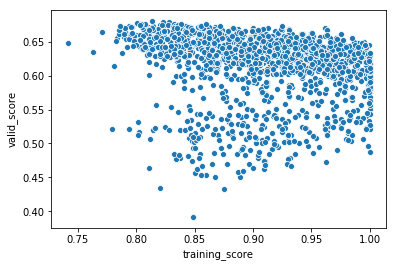

In [25]:
sns.scatterplot(runs_df['training_score'], runs_df['valid_score'])